# Setup, Constants, and Imports

In [1]:
import os
import sys
import logging

## Notebook Configs

In [2]:
IS_COLAB = 'google.colab' in sys.modules
OUTPUT_PROCESSED_FILES = True # TODO: Use this if you want to output save files (optional - see below)

if IS_COLAB:
    from google.colab import userdata
    GITHUB_USERNAME = userdata.get('github_user')
    GITHUB_TOKEN = userdata.get('github_token')
    GITHUB_EMAIL = userdata.get('github_email')

## Constants

In [3]:
REPO_URL = "https://github.com/EErlando/Quarterly-Bytes.git"
REPO_NAME = "src"
REPO_BRANCH = "JKW_Branch" # TODO: UPDATE THIS TO YOU BRANCH - DEFAULT TO MAIN
ALL_TRANSCRIPTS_PATH = "data/raw/JP Morgan/Transcripts"
NOTEBOOK_DIR = "notebooks" # TODO: UPDATE THIS TO YOUR NOTEBOOK DIRECTORY (e.g. 1_data_extraction_and_processing)

## Clone and Pull Latest from Repository - Colab Specific

In [4]:
if IS_COLAB:
    !git config pull.rebase false
    if os.path.exists(REPO_NAME):
        print(f"Directory '{REPO_NAME}' already exists. Pulling latest changes...")
        %cd {REPO_NAME}
        !git pull origin {REPO_BRANCH} --quiet
        %cd ..
    else:
        print(f"Cloning repository into '{REPO_NAME}'...")
        !git clone --quiet --branch {REPO_BRANCH} {REPO_URL} {REPO_NAME}
        print("Clone complete.")

    sys.path.append('/content/src/')
    %cd /content/src/
    !pip install -r requirements.txt
else:
    !pip install -r requirements.txt
    if os.path.basename(os.getcwd()) == NOTEBOOK_DIR:
        os.chdir('../') # TODO: UPDATE THIS TO ROOT OF REPO

logging.basicConfig(level=logging.ERROR, format='%(levelname)s: %(message)s')

fatal: not in a git directory
Cloning repository into 'src'...
Clone complete.
/content/src
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 118.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 95.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 63.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 108.9 MB/s eta 0:00:00
  Attempting uninstall: nvid

## Local Imports Example

In [ ]:
from src.utils.pdf_utils import BankType, extract_text_from_pdf

BankType.GOLDMAN_SACHS.value

'Goldman Sachs'

In [ ]:
extract_text_from_pdf("data/raw/Goldman Sachs/Transcripts/1q23_earnings_transcript.pdf")

"The Goldman Sachs Group, Inc. (GS) Q1\n2023 Earnings Call T ranscript\nApr. 18, 2023 1:05 PM ET |The Goldman Sachs Group, Inc. (GS) Stock , GS.PR.A  Stock , GS.PR.C\nStock , GS.PR.J Stock , GS.PR.D Stock , GS.PR.K Stock |GS, GS.PR.A , GS.PR.C ...\nWelcome to Seeking Alpha!\nArticles on GS are available to you for free for the next 30 days.\nTo continue receiving professional-grade analyses on  GS and gain access to similar insights\nacross the entire market, subscribe to Premium before your trial expires. Start today for only\n$4.95 for your ﬁrst month.\nQ1: 2023-04-18 Earnings Summary\nEPS of $8.79 beats by $0.73 \xa0|\xa0Revenue of $12.22B  (-5.48% Y/Y) misses by $423.93MTranscripts\nSA Transcripts\n153.88K  Follower s\nJoin Premium\nThe Goldman Sachs Group, Inc. ( NYSE: GS) Q1 2023 Earnings Conference Call\nApril 18, 2023 9:30 AM ET\nCompany Participants\nCarey Halio - Head of IR and Chief Strategy Ofﬁcer\nDavid Solomon - Chairman and CEO\nDenis Coleman - CFO\nConference Call Parti

# Save Data Example

In [ ]:
import pandas as pd

target_dir = 'data/temp/'
file_name = 'dummy_test_output_new.csv'
dummy_pf = pd.DataFrame({'from_colab': [IS_COLAB, True, 'hello']})


if OUTPUT_PROCESSED_FILES:
    if IS_COLAB:
        AUTHENTICATED_REPO_URL = REPO_URL.replace("https://", f"https://{GITHUB_USERNAME}:{GITHUB_TOKEN}@")
        dummy_pf.to_csv(f"{target_dir}{file_name}", index=False)

        # Configure Git user (important for committing)
        !git config user.email "{GITHUB_EMAIL}"
        !git config user.name "{GITHUB_USERNAME}"
        !git remote set-url origin {AUTHENTICATED_REPO_URL}

        # Add the file to staging
        !git add {target_dir}{file_name}
        print(f"Added '{target_dir}{file_name}' to staging.")

        # Commit the changes
        commit_message = f"Add new data file: {target_dir}{file_name}"
        !git commit -m "{commit_message}"
        print(f"Committed changes with message: '{commit_message}'")
        print(f"Attempted commit with message: '{commit_message}'")

        # Add this line to debug:
        print(f"Value of REPO_BRANCH before push: {REPO_BRANCH}")

        print("Pushing changes to GitHub. Please enter your GitHub username and Personal Access Token when prompted.")
        !git push --set-upstream origin {REPO_BRANCH} --force
        print("Push command executed. Check output for success or prompt.")
    else:
        dummy_pf.to_csv(f"{target_dir}{file_name}", index=False)
        print("Processed files saved successfully.")

Added 'data/temp/dummy_test_output_new.csv' to staging.
On branch LP_fix_colab_update_issue
Your branch is up to date with 'origin/LP_fix_colab_update_issue'.

nothing to commit, working tree clean
Committed changes with message: 'Add new data file: data/temp/dummy_test_output_new.csv'
Attempted commit with message: 'Add new data file: data/temp/dummy_test_output_new.csv'
Value of REPO_BRANCH before push: LP_fix_colab_update_issue
Pushing changes to GitHub. Please enter your GitHub username and Personal Access Token when prompted.
Branch 'LP_fix_colab_update_issue' set up to track remote branch 'LP_fix_colab_update_issue' from 'origin'.
Everything up-to-date
Push command executed. Check output for success or prompt.


# Sentiment Analysis

## Packages

In [5]:
# Install packages
! pip install transformers tensorflow nltk

In [6]:
# Import packages

# Primary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Transformers and Tensorflow
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
import tensorflow as tf

# NLTK
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
from nltk.tokenize import RegexpTokenizer
from nltk.probability import FreqDist

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


## Data

In [7]:
# Files

gs_discussion = '/content/src/data/processed/Goldman Sachs/discussion_df.csv'
gs_q_and_a = '/content/src/data/processed/Goldman Sachs/qna_df.csv'
jpm_discussion = '/content/src/data/processed/JP Morgan/discussion_df.csv'
jpm_q_and_a = '/content/src/data/processed/JP Morgan/qna_df.csv'

In [8]:
# Load files
df_gs_discussion = pd.read_csv(gs_discussion)
df_gs_q_and_a = pd.read_csv(gs_q_and_a)
df_jpm_discussion = pd.read_csv(jpm_discussion)
df_jpm_q_and_a = pd.read_csv(jpm_q_and_a)

In [9]:
df_jpm_discussion.head()

,speaker,role,company,content,year,quarter
0,Jeremy Barnum,Chief Financial Officer,JPMorgan Chase & Co.,"Thanks, operator. Good morning, everyone. The ...",2022,1
1,Jeremy Barnum,Chief Financial Officer,JPMorgan Chase & Co.,"Thanks, operator. Good morning, everyone. The ...",2022,2
2,Jeremy Barnum,Chief Financial Officer,JPMorgan Chase & Co.,"Thank you very much. Good morning, everyone. A...",2022,3
3,Jamie Dimon,"Chairman, Chief Executive Officer",JPMorgan Chase & Co.,"Yeah, Jeremy, thank you very much. Hello, ever...",2022,3
4,Jeremy Barnum,Chief Financial Officer,JPMorgan Chase & Co.,"Yeah. Thanks, Jamie. Let's go ahead and open u...",2022,3


In [10]:
df_jpm_discussion["role"].unique()

array(['Chief Financial Officer', 'Chairman, Chief Executive Officer'],
      dtype=object)

In [11]:
df_jpm_discussion["speaker"].unique()

array(['Jeremy Barnum', 'Jamie Dimon', 'Jamie  Dimon'], dtype=object)

In [12]:
df_jpm_q_and_a.head()

,question_order,question_answer_group_id,speaker,role,company,content,year,quarter
0,0,0,John E. McDonald,Analyst,Autonomous Research,"Thank you. Morning, Jeremy. Was wondering abou...",2022,1
1,1,0,Jeremy Barnum,Chief Financial Officer,JPMorgan Chase & Co.,"Good morning, John. Good question. Yeah, look,...",2022,1
2,2,0,John E. McDonald,Analyst,Autonomous Research,"Okay. And as my follow up, could you give us s...",2022,1
3,3,0,Jeremy Barnum,Chief Financial Officer,JPMorgan Chase & Co.,Yeah. I guess I would direct you to my comment...,2022,1
4,4,0,John E. McDonald,Analyst,Autonomous Research,Okay. Thanks.,2022,1


In [13]:
df_jpm_q_and_a["role"].unique()

array(['Analyst', 'Chief Financial Officer',
       'Chairman, Chief Executive Of ficer',
       'Chairman, Chief Executive Officer',
       'Chair man, Chief Executive Officer',
       'Chairman, Chief  Executive Officer', 'Chief Financ ial Officer',
       'Chief  Financial Officer',
       'Chief Financial Officer, Member -Operating Committee',
       'Chief Financial Officer, Member -Operating Comm ittee',
       'Chief Financial Officer, Member -Operating  Committee',
       'Chairman, Chief Execut ive Officer', 'Analy st',
       'Chief Financial Officer, M ember -Operating Committee',
       'Chief Financial Officer, Member -Oper ating Committee',
       'Chief Financial Officer, Membe r-Operating Committee',
       'Chief Fin ancial Officer, Member -Operating Committee',
       'Chairman, Chief Executive Off icer', 'Chief Financial Offi cer',
       'Chief Financial  Officer', 'C hief Executive Officer, Chairman',
       'Chie f Financial Officer', 'Chief Fina ncial Officer',
 

In [14]:
df_jpm_q_and_a["speaker"].unique()

array(['John E. McDonald', 'Jeremy Barnum', 'Ken Usdin',
       'Betsy L. Graseck', 'Jamie Dimon', 'Steven Ch ubak',
       'Steven Chubak', 'Glenn Schorr', 'Glenn Scho rr', 'Gerard Cassidy',
       'Mike Mayo', 'Matt O’Connor', 'James Mitchell',
       'Ebrahim H. Poonawala', 'Erika Najarian', 'Jeremy  Barnum',
       "Matt O'Connor", 'Jim Mitchell', 'Jeremy B arnum', 'Glenn  Schorr',
       'Charles W. Peabody', 'Andrew Lim', 'John McDonald',
       'Betsy L. Grasec k', 'Gerard  Cassidy', 'Mike M ayo',
       'Jere my Barnum', 'Jamie  Dimon', 'Ryan Kenny', 'Manan Gosalia',
       'Glenn S chorr', 'Charles W. Peabo dy', 'Saul Martinez',
       'Saul Mar tinez', 'Ebrahim Poonawala'], dtype=object)

In [15]:
df_gs_discussion.head()

,speaker,role,company,content,quarter,year
0,David Solomon,"Chairman, Chief Executive Ofﬁcer",Goldman Sachs,"Thank you, operator , good morning, everyone....",3,2024
1,Denis Coleman,Chief Financial Ofﬁcer,Goldman Sachs,"Thank you, David. Good morning. Let's start w...",3,2024
2,David Solomon,"CEO, Chairman",Goldman Sachs,"Thank you, operator , and good morning, every...",4,2024
3,Denis Coleman,CFO,Goldman Sachs,"Thank you, David, and good morning. Let's sta...",4,2024
4,Carey Halio,"Chief Strategy Ofﬁcer, Head of Investor Relations",Goldman Sachs,"Thank you. Good morning. This is Carey Halio,...",2,2023


In [16]:
df_gs_discussion["role"].unique()

array(['Chairman, Chief Executive Ofﬁcer', 'Chief Financial Ofﬁcer',
       'CEO, Chairman', 'CFO',
       'Chief Strategy Ofﬁcer, Head of Investor Relations',
       'Head of Investor Relations', 'Chief Executive Ofﬁcer',
       'Chief Strategy Ofﬁcer, Head of IR', 'Head, Investor Relations',
       'Investor Relations'], dtype=object)

In [17]:
df_gs_discussion["speaker"].unique()

array(['David Solomon', 'Denis Coleman', 'Carey Halio', 'Dennis Coleman'],
      dtype=object)

In [18]:
df_gs_q_and_a.head()

,question_order,question_answer_group_id,speaker,role,company,content_type,content,quarter,year
0,0,0,Glenn Schorr,NaN,Evercore,question,"so, trading question, i mean, markets busines...",3,2024
1,1,0,David Solomon,"Chairman, Chief Executive Ofﬁcer",Goldman Sachs,answer,"i appreciate the question, glenn, and i mean,...",3,2024
2,2,0,Glenn Schorr,NaN,Evercore,question,i appreciate that. this one will be a short f...,3,2024
3,3,0,Denis Coleman,Chief Financial Ofﬁcer,Goldman Sachs,answer,"glenn, its denis. i guess what i would sugges...",3,2024
4,0,1,Ebrahim Poonawala,NaN,Bank of America,question,i just had a follow-up ﬁrst on trading and ma...,3,2024


In [19]:
df_gs_q_and_a["speaker"].unique()

array(['Glenn Schorr', 'David Solomon', 'Denis Coleman',
       'Ebrahim Poonawala', 'Christian Bolu', 'Mike Mayo',
       'Betsy Graseck', 'Brennan Hawken', 'Steven Chubak', 'Devin Ryan',
       'Dan Fannon', 'Gerard Cassidy', 'Saul Martinez', 'Daniel Fannon',
       "Matt O'Connor", 'James Mitchell', 'Carey Halio', 'Jim Mitchell',
       'Andrew Lim', 'Ryan Kenny', 'Erika Najarian', 'Dennis Coleman',
       'Jeremy Sigee', 'Matt O’Connor', 'Michael Mayo',
       "Matthew O'Connor"], dtype=object)

In [20]:
df_gs_q_and_a["role"].unique()

array([nan, 'Chairman, Chief Executive Ofﬁcer', 'Chief Financial Ofﬁcer',
       'CEO, Chairman', 'CFO',
       'Chief Strategy Ofﬁcer, Head of Investor Relations',
       'Chief Executive Ofﬁcer'], dtype=object)

## Clean

### Goldman Sachs

In [21]:
# Clean Goldman Sachs Speaker names
df_gs_discussion["speaker"] = df_gs_discussion["speaker"].str.replace("Dennis Coleman", "Denis Coleman")
df_gs_discussion["speaker"].unique()

array(['David Solomon', 'Denis Coleman', 'Carey Halio'], dtype=object)

In [22]:
# Clean Goldman Sachs roles
df_gs_q_and_a['role'].unique()

array([nan, 'Chairman, Chief Executive Ofﬁcer', 'Chief Financial Ofﬁcer',
       'CEO, Chairman', 'CFO',
       'Chief Strategy Ofﬁcer, Head of Investor Relations',
       'Chief Executive Ofﬁcer'], dtype=object)

In [23]:
# Standardize the 'role' column in df_gs_q_and_a
# Convert roles to lowercase and remove leading/trailing whitespace
df_gs_q_and_a['role'] = df_gs_q_and_a['role'].str.lower().str.strip()

print(df_gs_q_and_a['role'].unique())

[nan 'chairman, chief executive ofﬁcer' 'chief financial ofﬁcer'
 'ceo, chairman' 'cfo' 'chief strategy ofﬁcer, head of investor relations'
 'chief executive ofﬁcer']


In [24]:
# Define a mapping for similar roles to a single standard
role_mapping = {
    'chairman, chief executive ofﬁcer': 'CEO',
    'ceo, chairman': 'CEO',
    'chief executive ofﬁcer': 'CEO',
    'chief financial ofﬁcer': 'CFO',
    'cfo': 'CFO',
    'chief strategy ofﬁcer, head of investor relations': 'HIR',
    np.nan: 'Analyst'


    # Add other mappings if necessary based on unique values
}

# Apply the mapping
df_gs_q_and_a['role'] = df_gs_q_and_a['role'].map(role_mapping)

# Check the unique roles after standardization
print(df_gs_q_and_a['role'].unique())

['Analyst' 'CEO' 'CFO' 'HIR']


In [25]:
df_gs_q_and_a["company"].unique()

array(['Evercore', 'Goldman Sachs', 'Bank of America',
       'Autonomous Research', 'W ells Fargo Securities', 'Morgan Stanley',
       'UBS', 'W olfe Research', 'Citizens JMP', 'Jef feries', 'RBC',
       'HSBC', 'W ells Fargo', 'JMP  Securities', 'Deutsche Bank',
       'RBC Capital Markets', 'Seaport Global', 'Autonomous',
       'Societe Generale', 'Evercore ISI', 'Citizens',
       'Seaport Global Securities', 'Citizens JMP  Securities',
       'BNP  Paribas'], dtype=object)

In [26]:
df_gs_q_and_a.head()

,question_order,question_answer_group_id,speaker,role,company,content_type,content,quarter,year
0,0,0,Glenn Schorr,Analyst,Evercore,question,"so, trading question, i mean, markets busines...",3,2024
1,1,0,David Solomon,CEO,Goldman Sachs,answer,"i appreciate the question, glenn, and i mean,...",3,2024
2,2,0,Glenn Schorr,Analyst,Evercore,question,i appreciate that. this one will be a short f...,3,2024
3,3,0,Denis Coleman,CFO,Goldman Sachs,answer,"glenn, its denis. i guess what i would sugges...",3,2024
4,0,1,Ebrahim Poonawala,Analyst,Bank of America,question,i just had a follow-up ﬁrst on trading and ma...,3,2024


In [27]:
company_mapping = {
    'Evercore' :  'Evercore',
    'Goldman Sachs' : 'Goldman Sachs',
    'Bank of America' : 'Bank of America',
    'Autonomous Research': 'Autonomous Research',
    'W ells Fargo Securities': 'Wells Fargo',
    'Morgan Stanley': 'Morgan Stanley',
    'UBS': 'UBS',
    'W olfe Research': 'Wolfe Research',
    'Citizens JMP': 'Citizens JMP',
    'Jef feries': 'Jeffries',
    'RBC': 'RBC',
    'HSBC': 'HSBC',
    'W ells Fargo': 'Wells Fargo',
    'JMP  Securities': 'Citizens JMP',
    'Deutsche Bank': 'Deutsche Bank',
    'RBC Capital Markets': 'RBC',
    'Seaport Global': 'Seaport Global' ,
    'Autonomous': 'Autonomous Research',
    'Societe Generale': 'Societe Generale',
    'Evercore ISI': 'Evercore',
    'Citizens' : 'Citizens JMP',
    'Seaport Global Securities': 'Seaport Global',
    'Citizens JMP  Securities': 'Citizens JMP',
    'BNP  Paribas' : 'BNP Paribas',
}

In [28]:
# Apply the mapping
df_gs_q_and_a['company'] = df_gs_q_and_a['company'].map(company_mapping)

# Check the unique companies after standardization
print(df_gs_q_and_a['company'].unique())

['Evercore' 'Goldman Sachs' 'Bank of America' 'Autonomous Research'
 'Wells Fargo' 'Morgan Stanley' 'UBS' 'Wolfe Research' 'Citizens JMP'
 'Jeffries' 'RBC' 'HSBC' 'Deutsche Bank' 'Seaport Global'
 'Societe Generale' 'BNP Paribas']


In [29]:
df_gs_discussion['company'].unique()

array(['Goldman Sachs'], dtype=object)

In [30]:
df_gs_discussion['role'].unique()

array(['Chairman, Chief Executive Ofﬁcer', 'Chief Financial Ofﬁcer',
       'CEO, Chairman', 'CFO',
       'Chief Strategy Ofﬁcer, Head of Investor Relations',
       'Head of Investor Relations', 'Chief Executive Ofﬁcer',
       'Chief Strategy Ofﬁcer, Head of IR', 'Head, Investor Relations',
       'Investor Relations'], dtype=object)

In [31]:
df_gs_discussion.head()

,speaker,role,company,content,quarter,year
0,David Solomon,"Chairman, Chief Executive Ofﬁcer",Goldman Sachs,"Thank you, operator , good morning, everyone....",3,2024
1,Denis Coleman,Chief Financial Ofﬁcer,Goldman Sachs,"Thank you, David. Good morning. Let's start w...",3,2024
2,David Solomon,"CEO, Chairman",Goldman Sachs,"Thank you, operator , and good morning, every...",4,2024
3,Denis Coleman,CFO,Goldman Sachs,"Thank you, David, and good morning. Let's sta...",4,2024
4,Carey Halio,"Chief Strategy Ofﬁcer, Head of Investor Relations",Goldman Sachs,"Thank you. Good morning. This is Carey Halio,...",2,2023


In [32]:
role_mapping_discussion = {
    'Chairman, Chief Executive Ofﬁcer': 'CEO',
    'Chief Financial Ofﬁcer': 'CFO',
    'CEO, Chairman': 'CEO',
    'CFO': 'CFO',
    'Chief Strategy Ofﬁcer, Head of Investor Relations': 'HIR',
    'Head of Investor Relations': 'HIR',
    'Chief Executive Ofﬁcer': 'CEO',
    'Chief Strategy Ofﬁcer, Head of IR':'HIR',
    'Head, Investor Relations': 'HIR',
    'Investor Relations': 'HIR'
}

In [33]:
# Apply the mapping
df_gs_discussion['role'] = df_gs_discussion['role'].map(role_mapping_discussion)

# Check the unique companies after standardization
print(df_gs_discussion['role'].unique())

['CEO' 'CFO' 'HIR']


In [34]:
df_gs_discussion.head()

,speaker,role,company,content,quarter,year
0,David Solomon,CEO,Goldman Sachs,"Thank you, operator , good morning, everyone....",3,2024
1,Denis Coleman,CFO,Goldman Sachs,"Thank you, David. Good morning. Let's start w...",3,2024
2,David Solomon,CEO,Goldman Sachs,"Thank you, operator , and good morning, every...",4,2024
3,Denis Coleman,CFO,Goldman Sachs,"Thank you, David, and good morning. Let's sta...",4,2024
4,Carey Halio,HIR,Goldman Sachs,"Thank you. Good morning. This is Carey Halio,...",2,2023


In [35]:
gs_speaker_mapping = {
    'Glenn Schorr' :  'Glenn Schorr',
    'Jeremy Barnum' :  'Jeremy Barnum',
    'David Solomon' : 'David Solomon',
    'Denis Coleman' :  'Denis Coleman',
    'Ebrahim Poonawala': 'Ebrahim Poonawala',
    'Christian Bolu': 'Christian Bolu',
    'Mike Mayo' :  'Mike Mayo',
    'Betsy Graseck' : 'Betsy Graseck',
    'Brennan Hawken' : 'Brennan Hawken',
    'Steven Chubak' : 'Steven Chubak',
    'Devin Ryan' : 'Devin Ryan',
    'Dan Fannon' : 'Dan Fannon',
    'Gerard Cassidy' : 'Gerard Cassidy',
    'Saul Martinez' : 'Saul Martinez',
    'Daniel Fannon' :  'Daniel Fannon',
    "Matt O'Connor" : 'Matt O’Connor',
    'James Mitchell' : 'James Mitchell',
    'Carey Halio' : 'Carey Halio',
    'Jim Mitchell': 'Jim Mitchell',
    'Andrew Lim' :  'Andrew Lim',
    'Ryan Kenny' : 'Ryan Kenny',
    'Erika Najarian' : 'Erika Najarian',
    'Dennis Coleman' : 'Denis Coleman',
    'Jeremy Sigee' : 'Jeremy Sigee',
    'Matt O’Connor': 'Matt O’Connor',
    'Michael Mayo' : 'Mike Mayo',
    "Matthew O'Connor": 'Matt O’Connor'

}

In [36]:
df_gs_q_and_a['speaker'] = df_gs_q_and_a['speaker'].map(gs_speaker_mapping)

# Check the unique companies after standardization
print(df_gs_q_and_a['speaker'].unique())

['Glenn Schorr' 'David Solomon' 'Denis Coleman' 'Ebrahim Poonawala'
 'Christian Bolu' 'Mike Mayo' 'Betsy Graseck' 'Brennan Hawken'
 'Steven Chubak' 'Devin Ryan' 'Dan Fannon' 'Gerard Cassidy'
 'Saul Martinez' 'Daniel Fannon' 'Matt O’Connor' 'James Mitchell'
 'Carey Halio' 'Jim Mitchell' 'Andrew Lim' 'Ryan Kenny' 'Erika Najarian'
 'Jeremy Sigee']


### JP Morgan Chase

In [37]:
df_jpm_discussion.head()

,speaker,role,company,content,year,quarter
0,Jeremy Barnum,Chief Financial Officer,JPMorgan Chase & Co.,"Thanks, operator. Good morning, everyone. The ...",2022,1
1,Jeremy Barnum,Chief Financial Officer,JPMorgan Chase & Co.,"Thanks, operator. Good morning, everyone. The ...",2022,2
2,Jeremy Barnum,Chief Financial Officer,JPMorgan Chase & Co.,"Thank you very much. Good morning, everyone. A...",2022,3
3,Jamie Dimon,"Chairman, Chief Executive Officer",JPMorgan Chase & Co.,"Yeah, Jeremy, thank you very much. Hello, ever...",2022,3
4,Jeremy Barnum,Chief Financial Officer,JPMorgan Chase & Co.,"Yeah. Thanks, Jamie. Let's go ahead and open u...",2022,3


In [38]:
print(df_jpm_discussion["speaker"].unique())
print(df_jpm_discussion["role"].unique())
print(df_jpm_discussion["company"].unique())


['Jeremy Barnum' 'Jamie Dimon' 'Jamie  Dimon']
['Chief Financial Officer' 'Chairman, Chief Executive Officer']
['JPMorgan Chase & Co.']


In [39]:
df_jpm_discussion["speaker"] = df_jpm_discussion["speaker"].str.replace("Jamie  Dimon", "Jamie Dimon")
df_jpm_discussion["speaker"].unique()

array(['Jeremy Barnum', 'Jamie Dimon'], dtype=object)

In [40]:
df_jpm_discussion["role"] = df_jpm_discussion["role"].str.replace("Chairman, Chief Executive Officer", "CEO")
df_jpm_discussion["role"] = df_jpm_discussion["role"].str.replace("Chief Financial Officer", "CFO")
df_jpm_discussion["role"].unique()

array(['CFO', 'CEO'], dtype=object)

In [41]:
df_jpm_q_and_a.head()

,question_order,question_answer_group_id,speaker,role,company,content,year,quarter
0,0,0,John E. McDonald,Analyst,Autonomous Research,"Thank you. Morning, Jeremy. Was wondering abou...",2022,1
1,1,0,Jeremy Barnum,Chief Financial Officer,JPMorgan Chase & Co.,"Good morning, John. Good question. Yeah, look,...",2022,1
2,2,0,John E. McDonald,Analyst,Autonomous Research,"Okay. And as my follow up, could you give us s...",2022,1
3,3,0,Jeremy Barnum,Chief Financial Officer,JPMorgan Chase & Co.,Yeah. I guess I would direct you to my comment...,2022,1
4,4,0,John E. McDonald,Analyst,Autonomous Research,Okay. Thanks.,2022,1


In [42]:
print(df_jpm_q_and_a["speaker"].unique())

['John E. McDonald' 'Jeremy Barnum' 'Ken Usdin' 'Betsy L. Graseck'
 'Jamie Dimon' 'Steven Ch ubak' 'Steven Chubak' 'Glenn Schorr'
 'Glenn Scho rr' 'Gerard Cassidy' 'Mike Mayo' 'Matt O’Connor'
 'James Mitchell' 'Ebrahim H. Poonawala' 'Erika Najarian' 'Jeremy  Barnum'
 "Matt O'Connor" 'Jim Mitchell' 'Jeremy B arnum' 'Glenn  Schorr'
 'Charles W. Peabody' 'Andrew Lim' 'John McDonald' 'Betsy L. Grasec k'
 'Gerard  Cassidy' 'Mike M ayo' 'Jere my Barnum' 'Jamie  Dimon'
 'Ryan Kenny' 'Manan Gosalia' 'Glenn S chorr' 'Charles W. Peabo dy'
 'Saul Martinez' 'Saul Mar tinez' 'Ebrahim Poonawala']


In [43]:
jpm_q_and_a_speakers_mapping = {'John E. McDonald' :  'John McDonald',
 'Jeremy Barnum': 'Jeremy Barnum',
 'Ken Usdin' : 'Ken Usdin',
 'Betsy L. Graseck' : 'Betsy L. Graseck',
 'Jamie Dimon' : 'Jamie Dimon',
 'Steven Ch ubak' : 'Steven Chubak',
 'Steven Chubak': 'Steven Chubak',
 'Glenn Schorr' : 'Glenn Schorr',
 'Glenn Scho rr': 'Glenn Schorr',
 'Gerard Cassidy': 'Gerard Cassidy',
 'Mike Mayo': 'Mike Mayo',
 'Matt O’Connor': 'Matt O’Connor',
 'James Mitchell': "James Mitchell",
 'Ebrahim H. Poonawala': 'Ebrahim Poonawala',
 'Erika Najarian': 'Erika Najarian',
 'Jeremy  Barnum' :  'Jeremy Barnum',
 "Matt O'Connor": 'Matt O’Connor',
 'Jim Mitchell': 'Jim Mitchell',
 'Jeremy B arnum': 'Jeremy Barnum',
 'Glenn  Schorr' :  'Glenn Schorr',
 'Charles W. Peabody': 'Charles W. Peabody',
 'Andrew Lim' : 'Andrew Lim',
 'John McDonald' : 'John McDonald',
 'Betsy L. Grasec k' : 'Betsy L. Graseck',
 'Gerard  Cassidy' : 'Gerard Cassidy',
 'Mike M ayo' : 'Mike Mayo',
 'Jere my Barnum' :  'Jeremy Barnum',
 'Jamie  Dimon' :  'Jamie Dimon',
 'Ryan Kenny' :  'Ryan Kenny',
 'Manan Gosalia' :  'Manan Gosalia',
 'Glenn S chorr' :  'Glenn Schorr',
 'Charles W. Peabo dy' : 'Charles W. Peabody',
 'Saul Martinez' : 'Saul Martinez',
 'Saul Mar tinez' : 'Saul Martinez',
 'Ebrahim Poonawala' : 'Ebrahim Poonawala'}

In [44]:
# Apply the mapping
df_jpm_q_and_a['speaker'] = df_jpm_q_and_a['speaker'].map(jpm_q_and_a_speakers_mapping)
# Check the unique companies after standardization
print(df_jpm_q_and_a['speaker'].unique())

['John McDonald' 'Jeremy Barnum' 'Ken Usdin' 'Betsy L. Graseck'
 'Jamie Dimon' 'Steven Chubak' 'Glenn Schorr' 'Gerard Cassidy' 'Mike Mayo'
 'Matt O’Connor' 'James Mitchell' 'Ebrahim Poonawala' 'Erika Najarian'
 'Jim Mitchell' 'Charles W. Peabody' 'Andrew Lim' 'Ryan Kenny'
 'Manan Gosalia' 'Saul Martinez']


In [45]:
df_jpm_q_and_a.head()

,question_order,question_answer_group_id,speaker,role,company,content,year,quarter
0,0,0,John McDonald,Analyst,Autonomous Research,"Thank you. Morning, Jeremy. Was wondering abou...",2022,1
1,1,0,Jeremy Barnum,Chief Financial Officer,JPMorgan Chase & Co.,"Good morning, John. Good question. Yeah, look,...",2022,1
2,2,0,John McDonald,Analyst,Autonomous Research,"Okay. And as my follow up, could you give us s...",2022,1
3,3,0,Jeremy Barnum,Chief Financial Officer,JPMorgan Chase & Co.,Yeah. I guess I would direct you to my comment...,2022,1
4,4,0,John McDonald,Analyst,Autonomous Research,Okay. Thanks.,2022,1


In [46]:
print(df_jpm_q_and_a["role"].unique())

['Analyst' 'Chief Financial Officer' 'Chairman, Chief Executive Of ficer'
 'Chairman, Chief Executive Officer' 'Chair man, Chief Executive Officer'
 'Chairman, Chief  Executive Officer' 'Chief Financ ial Officer'
 'Chief  Financial Officer'
 'Chief Financial Officer, Member -Operating Committee'
 'Chief Financial Officer, Member -Operating Comm ittee'
 'Chief Financial Officer, Member -Operating  Committee'
 'Chairman, Chief Execut ive Officer' 'Analy st'
 'Chief Financial Officer, M ember -Operating Committee'
 'Chief Financial Officer, Member -Oper ating Committee'
 'Chief Financial Officer, Membe r-Operating Committee'
 'Chief Fin ancial Officer, Member -Operating Committee'
 'Chairman, Chief Executive Off icer' 'Chief Financial Offi cer'
 'Chief Financial  Officer' 'C hief Executive Officer, Chairman'
 'Chie f Financial Officer' 'Chief Fina ncial Officer'
 'Chief Fin ancial Officer' 'Ch ief Executive Officer, Chairman'
 'Chief Financia l Officer' 'Chief Finan cial Officer'
 'Chief 

In [47]:
jpm_q_and_a_role_mapping = {'Analyst' : 'Analyst',
                            'Chief Financial Officer': 'CFO',
                            'Chairman, Chief Executive Of ficer': 'CEO',
                            'Chairman, Chief Executive Officer': 'CEO',
                            'Chair man, Chief Executive Officer' : 'CEO',
                            'Chairman, Chief  Executive Officer' : 'CEO',
                            'Chief Financ ial Officer' : 'CFO',
                            'Chief  Financial Officer': 'CFO',
                            'Chief Financial Officer, Member -Operating Committee': 'CFO',
                            'Chief Financial Officer, Member -Operating Comm ittee': 'CFO',
                            'Chief Financial Officer, Member -Operating  Committee' : 'CFO',
                            'Chairman, Chief Execut ive Officer': 'CEO',
                            'Analy st' : 'Analyst',
                            'Chief Financial Officer, M ember -Operating Committee' : 'CFO',
                            'Chief Financial Officer, Member -Oper ating Committee': 'CFO',
                            'Chief Financial Officer, Membe r-Operating Committee': 'CFO',
                            'Chief Fin ancial Officer, Member -Operating Committee' : 'CFO',
                            'Chairman, Chief Executive Off icer' : 'CEO',
                            'Chief Financial Offi cer' : 'CFO',
                            'Chief Financial  Officer' :  'CFO',
                            'C hief Executive Officer, Chairman' : 'CEO',
                            'Chie f Financial Officer' : 'CFO',
                            'Chief Fina ncial Officer' :  'CFO',
                            'Chief Fin ancial Officer' :  'CFO',
                            'Ch ief Executive Officer, Chairman': 'CEO',
                            'Chief Financia l Officer':  'CFO',
                            'Chief Finan cial Officer' : 'CFO',
                            'Chief Financi al Officer':  'CFO',
                            'Cha irman, Chief Executive Officer': 'CEO' }

In [48]:
# Apply role mapping
df_jpm_q_and_a['role'] = df_jpm_q_and_a['role'].map(jpm_q_and_a_role_mapping)
# Check the unique companies after standardization
print(df_jpm_q_and_a['role'].unique())

['Analyst' 'CFO' 'CEO']


In [49]:
df_jpm_q_and_a['company'].unique()

array(['Autonomous Research', 'JPMorgan Chase & Co.', 'Jefferies LLC',
       'Morgan Stanley & Co. LLC', 'Wolfe Research LLC', 'Evercore ISI',
       'Evercore  ISI', 'RBC Capital Markets LLC',
       'Wells Fargo Securities LLC', 'Inc.', 'In c.',
       'Seaport Global Securities', 'Seap ort Global Securities',
       'UBS Securities LLC', 'Ever core ISI', 'JPMo rgan Chase & Co.',
       'JPMor gan Chase & Co.', 'Morgan Stanley & Co. LL C',
       'M organ Stanley  & Co. LLC', 'Jefferies & Company',
       'Jefferies & C ompany', 'Wells  Fargo Securities LLC',
       'Bank of America Merrill Lynch', 'JPM organ Chase & Co.',
       'Seapor t Global Securities', 'Wells Farg o Securities LLC',
       'JPMorg an Chase & Co.', 'Mor gan Stanley & Co. LLC',
       'Evercor e ISI', 'Portales Partners', 'UBS S ecurities LLC',
       'Bank  of America Merrill Lynch', 'Bank of Ame rica Merrill Lynch',
       'Ev ercore ISI', 'RBC C apital Markets LLC',
       'Morg an Stanley & Co. LLC', 'Socié

In [50]:
jpm_q_and_a_company_mapping = {
    'Autonomous Research' : 'Autonomous Research',
    'JPMorgan Chase & Co.': 'JP Morgan Chase & Co.',
    'Jefferies LLC': 'Jeffries',
    'Morgan Stanley & Co. LLC': 'Morgan Stanley & Co.',
    'Wolfe Research LLC' : 'Wolfe Research',
    'Evercore ISI' : 'Evercore',
    'Evercore  ISI': 'Evercore',
    'RBC Capital Markets LLC': 'RBC',
    'Wells Fargo Securities LLC' : 'Wells Fargo',
    'Inc.' : 'Inc.',
    'In c.' : 'Inc.',
    'Seaport Global Securities' : 'Seaport Global',
    'Seap ort Global Securities' : 'Seaport Global',
    'UBS Securities LLC' : 'UBS',
    'Ever core ISI': 'Evercore',
    'Evercore' : 'Evercore',
    'JPMo rgan Chase & Co.' : 'JP Morgan Chase & Co.',
    'JPMor gan Chase & Co.': 'JP Morgan Chase & Co.',
    'Morgan Stanley & Co. LL C' : 'Morgan Stanley & Co.',
    'M organ Stanley  & Co. LLC': 'Morgan Stanley & Co.',
    'Jefferies & Company': 'Jeffries',
    'Jefferies & C ompany': 'Jeffries',
    'Wells  Fargo Securities LLC' : 'Wells Fargo',
    'Bank of America Merrill Lynch' :  'Bank of America',
    'JPM organ Chase & Co.' :  'JP Morgan Chase & Co.',
    'Seapor t Global Securities' : 'Seaport Global',
    'Wells Farg o Securities LLC' : 'Wells Fargo',
    'JPMorg an Chase & Co.': 'JP Morgan Chase & Co.',
    'Mor gan Stanley & Co. LLC' : 'Morgan Stanley & Co.',
    'Evercor e ISI': 'Evercore',
    'Portales Partners' : 'Portales Partners',
    'UBS S ecurities LLC' :  'UBS',
    'Bank  of America Merrill Lynch' : 'Bank of America',
    'Bank of Ame rica Merrill Lynch' : 'Bank of America',
    'Ev ercore ISI' : 'Evercore',
    'RBC C apital Markets LLC' :  'RBC',
    'Morg an Stanley & Co. LLC' : 'Morgan Stanley & Co.',
    'Société Générale' : ' Societe Generale',
    'Auton omous Research':  'Autonomous Research',
    'Seaport Global Securities LLC': 'Seaport Global',
    'Seaport  Global Securities LLC' :  'Seaport Global',
    'Wells Fargo  Securities LLC' :  'Wells Fargo',
    'Well s Fargo Securities LLC' : 'Wells Fargo',
    'Autonomous  Research' :  'Autonomous Research',
    'Autono mous Research' : 'Autonomous Research',
    'Bank of America M errill Lynch' : 'Bank of America',
    'P ortales Partners LLC' :  'Portales Partners',
    'Portales Partners LLC': 'Portales Partners',
    'Bank of Amer ica Merrill Lynch' : 'Bank of America',

    'JPMorga n Chase & Co.': 'JP Morgan Chase & Co.',
    'Seapor t Global Securities LLC' :  'Seaport Global',
    'Morgan  Stanley & Co. LLC' :  'Morgan Stanley & Co.',
    'Po rtales Partners LLC' : 'Portales Partners',
    'JPMo rgan Chase & Co .' :  'JP Morgan Chase & Co.',
    'I nc.': 'Inc.',
    'Inc': 'Inc.',
    'RBC Ca pital Markets LLC': 'RBC',
    'Inc .': 'Inc.',
    'Truist Securities Inc.' : 'Truist Securities',
    'Well Fargo Securities LLC' :  'Wells Fargo',
    'Evercore Group LLC' : 'Evercore',
}

In [51]:
# Apply company mapping
df_jpm_q_and_a['company'] = df_jpm_q_and_a['company'].map(jpm_q_and_a_company_mapping)
# Check the unique companies after standardization
print(df_jpm_q_and_a['company'].unique())

['Autonomous Research' 'JP Morgan Chase & Co.' 'Jeffries'
 'Morgan Stanley & Co.' 'Wolfe Research' 'Evercore' 'RBC' 'Wells Fargo'
 'Inc.' 'Seaport Global' 'UBS' 'Bank of America' 'Portales Partners'
 ' Societe Generale' 'Truist Securities']


In [52]:
df_jpm_q_and_a.head()

,question_order,question_answer_group_id,speaker,role,company,content,year,quarter
0,0,0,John McDonald,Analyst,Autonomous Research,"Thank you. Morning, Jeremy. Was wondering abou...",2022,1
1,1,0,Jeremy Barnum,CFO,JP Morgan Chase & Co.,"Good morning, John. Good question. Yeah, look,...",2022,1
2,2,0,John McDonald,Analyst,Autonomous Research,"Okay. And as my follow up, could you give us s...",2022,1
3,3,0,Jeremy Barnum,CFO,JP Morgan Chase & Co.,Yeah. I guess I would direct you to my comment...,2022,1
4,4,0,John McDonald,Analyst,Autonomous Research,Okay. Thanks.,2022,1


In [53]:
print(df_jpm_q_and_a['role'].unique())

['Analyst' 'CFO' 'CEO']


In [54]:
print(df_jpm_discussion['role'].unique())

['CFO' 'CEO']


## Model

In [55]:
MODEL_NAME_1 = "yiyanghkust/finbert-tone"

In [56]:
MODEL_NAME_2 = "ProsusAI/finbert"

In [57]:
def score_m_d(df, model):

  df =  df.copy()
  df = df.sort_values(by=["year", "quarter"])
  df = df.reset_index(drop=True)

  # Initialize tokenizer and model
  max_length = 512

  tokenizer = AutoTokenizer.from_pretrained(model)
  model     = AutoModelForSequenceClassification.from_pretrained(model)

  # instantiate pipeline
  nlp = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

  contents = df["content"]
  # Add score and label column to df
  df["score"] = None
  df["label"] = None

  # Initialize empty lists to store scores and labels
  scores = []
  labels = []

  for content in contents:
    results = nlp(content, truncation=True, max_length=max_length)
    scores.append(results[0]["score"])
    labels.append(results[0]["label"])

  df['score'] = scores
  df['label'] = labels


  return df

## JP Morgan Chase

### Management Discussion

In [101]:
# yiyanghkust/finbert-tone
df_jpm_scored_md_kust = score_m_d(df_jpm_discussion,MODEL_NAME_1)
df_jpm_scored_md_kust.head()

Device set to use cuda:0


,speaker,role,company,content,year,quarter,score,label
0,Jeremy Barnum,CFO,JPMorgan Chase & Co.,"Thanks, operator. Good morning, everyone. The ...",2022,1,0.999922,Positive
1,Jeremy Barnum,CFO,JPMorgan Chase & Co.,"Thanks, operator. Good morning, everyone. The ...",2022,2,0.999990,Positive
2,Jeremy Barnum,CFO,JPMorgan Chase & Co.,"Thank you very much. Good morning, everyone. A...",2022,3,0.999994,Positive
3,Jamie Dimon,CEO,JPMorgan Chase & Co.,"Yeah, Jeremy, thank you very much. Hello, ever...",2022,3,0.924651,Neutral
4,Jeremy Barnum,CFO,JPMorgan Chase & Co.,"Yeah. Thanks, Jamie. Let's go ahead and open u...",2022,3,0.998837,Neutral


In [102]:
# ProsusAI/finbert
df_jpm_scored_md_prosus = score_m_d(df_jpm_discussion,MODEL_NAME_2)
df_jpm_scored_md_prosus.head()

Device set to use cuda:0


,speaker,role,company,content,year,quarter,score,label
0,Jeremy Barnum,CFO,JPMorgan Chase & Co.,"Thanks, operator. Good morning, everyone. The ...",2022,1,0.962026,negative
1,Jeremy Barnum,CFO,JPMorgan Chase & Co.,"Thanks, operator. Good morning, everyone. The ...",2022,2,0.941771,positive
2,Jeremy Barnum,CFO,JPMorgan Chase & Co.,"Thank you very much. Good morning, everyone. A...",2022,3,0.939475,positive
3,Jamie Dimon,CEO,JPMorgan Chase & Co.,"Yeah, Jeremy, thank you very much. Hello, ever...",2022,3,0.710301,neutral
4,Jeremy Barnum,CFO,JPMorgan Chase & Co.,"Yeah. Thanks, Jamie. Let's go ahead and open u...",2022,3,0.913243,neutral


#### Comparison Graphs

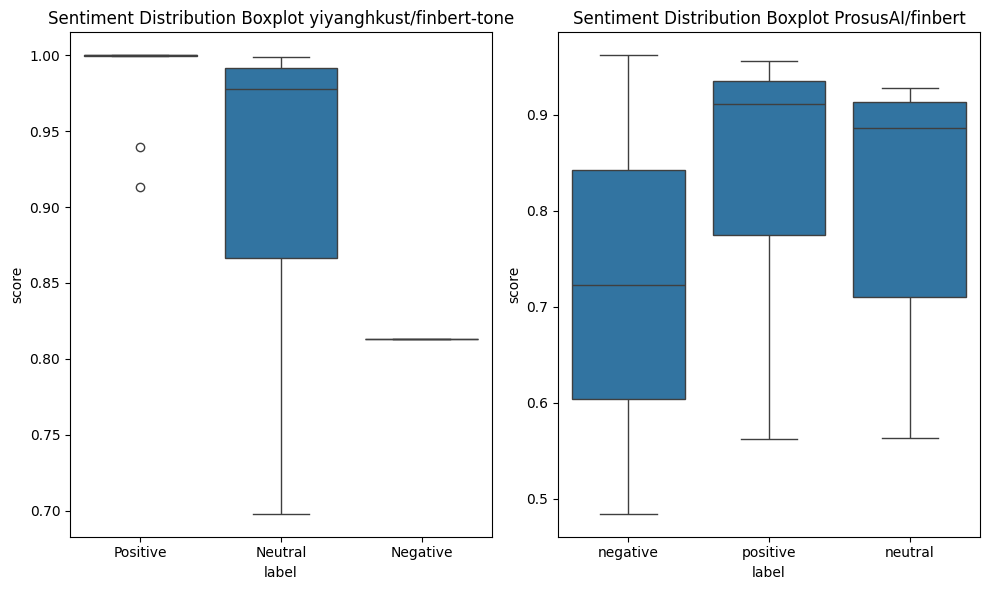

In [103]:
# Graph side by side boxplots
fig, ax = plt.subplots(1,2, figsize=(10, 6))

sns.boxplot(data=df_jpm_scored_md_kust, x="label", y="score", ax=ax[0])
sns.boxplot(data=df_jpm_scored_md_prosus, x="label", y="score", ax=ax[1])

ax[0].set_title("Sentiment Distribution Boxplot yiyanghkust/finbert-tone")
ax[1].set_title("Sentiment Distribution Boxplot ProsusAI/finbert")

plt.tight_layout()
plt.show()

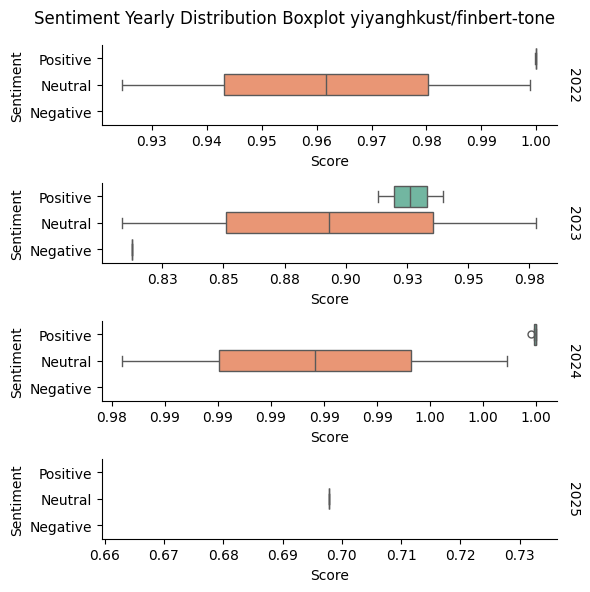

In [104]:
# Graph side by side boxplots of yearly distribution
g_1 = sns.catplot(
    data=df_jpm_scored_md_kust,
    x="score", y="label", row="year",
    kind="box", orient="h",
    sharex=False, margin_titles=True,
    height=1.5, aspect=4,
    palette="Set2"
)
g_1.set(xlabel="Score", ylabel="Sentiment")
g_1.set_titles(row_template="{row_name}")
for ax in g_1.axes.flat:
    ax.xaxis.set_major_formatter('{x:.2f}')

plt.suptitle("Sentiment Yearly Distribution Boxplot yiyanghkust/finbert-tone")


plt.tight_layout()
plt.show()

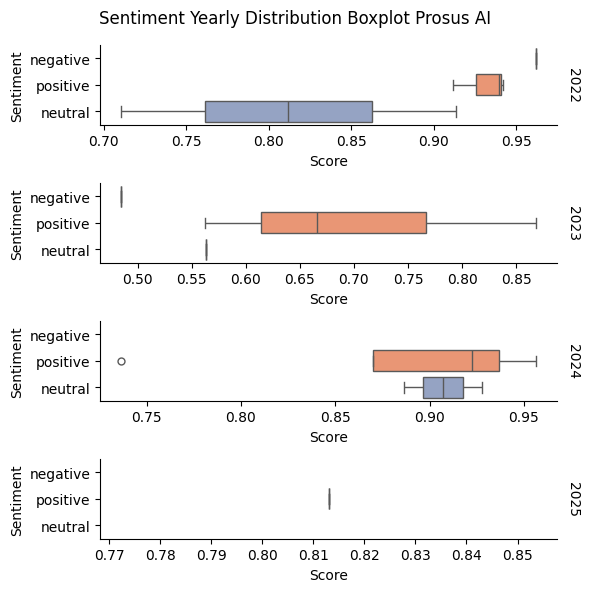

In [105]:
# Graph side by side boxplots of yearly distribution
g_2 = sns.catplot(
    data=df_jpm_scored_md_prosus,
    x="score", y="label", row="year",
    kind="box", orient="h",
    sharex=False, margin_titles=True,
    height=1.5, aspect=4,
    palette="Set2"
)
g_2.set(xlabel="Score", ylabel="Sentiment")
g_2.set_titles(row_template="{row_name}")
for ax in g_2.axes.flat:
    ax.xaxis.set_major_formatter('{x:.2f}')

plt.suptitle("Sentiment Yearly Distribution Boxplot Prosus AI")


plt.tight_layout()
plt.show()

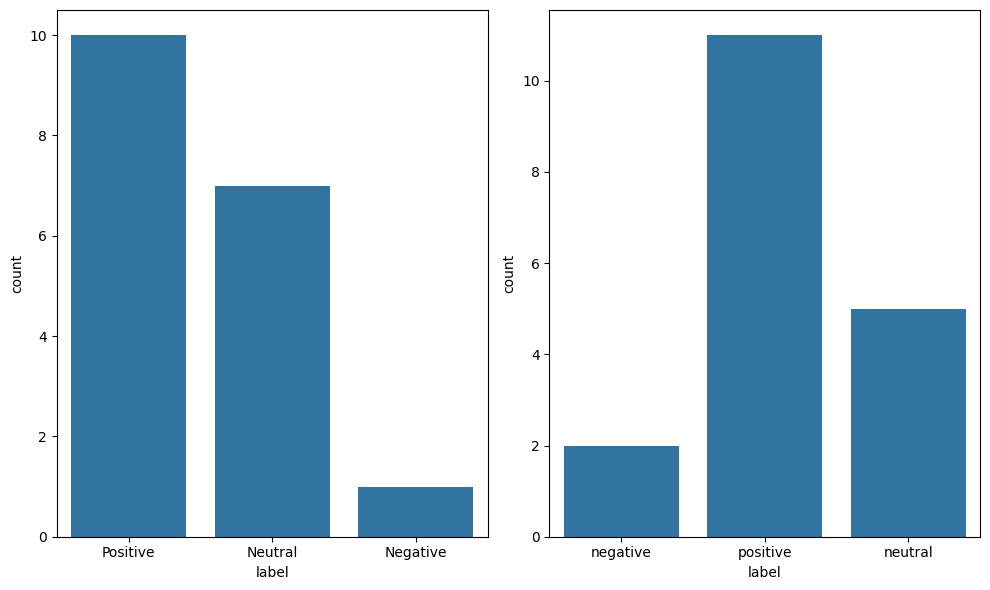

In [106]:
# Graph side by side distribution
fig, ax = plt.subplots(1,2, figsize=(10, 6))

sns.countplot(data=df_jpm_scored_md_kust, x="label", ax=ax[0])
sns.countplot(data=df_jpm_scored_md_prosus, x="label", ax=ax[1])

plt.tight_layout()
plt.show()

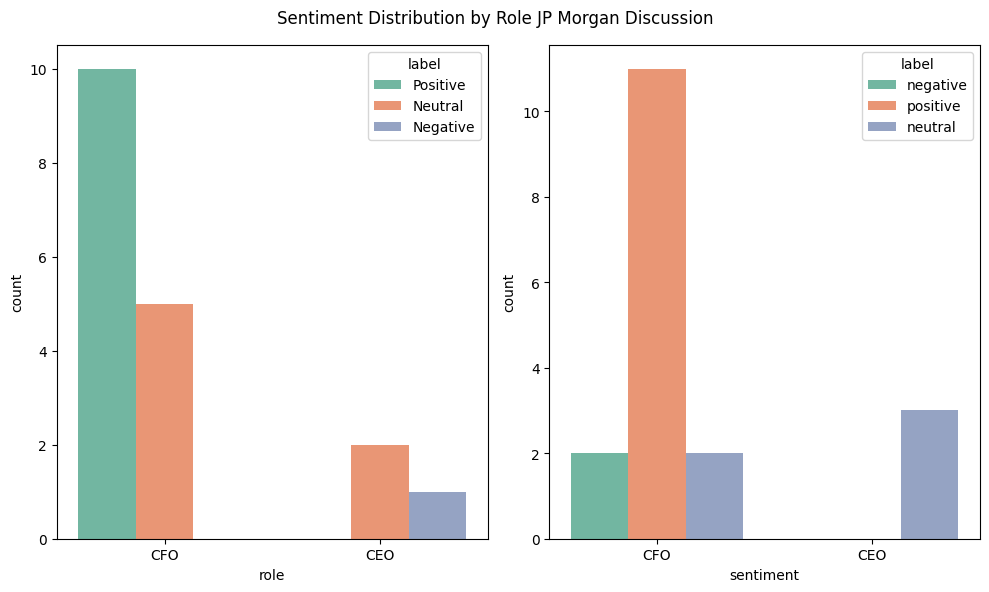

In [107]:
# Graph setiment distribution by role
fig, ax = plt.subplots(1,2, figsize=(10, 6))

sns.countplot(df_jpm_scored_md_kust,
              x="role", hue="label",
              orient = 'h', palette="Set2", ax=ax[0])

sns.countplot(df_jpm_scored_md_prosus,
              x="role", hue="label",
              orient = 'h', palette="Set2", ax=ax[1])


plt.suptitle("Sentiment Distribution by Role JP Morgan Discussion")
plt.xlabel("sentiment")
plt.ylabel("count")

plt.tight_layout()
plt.show()



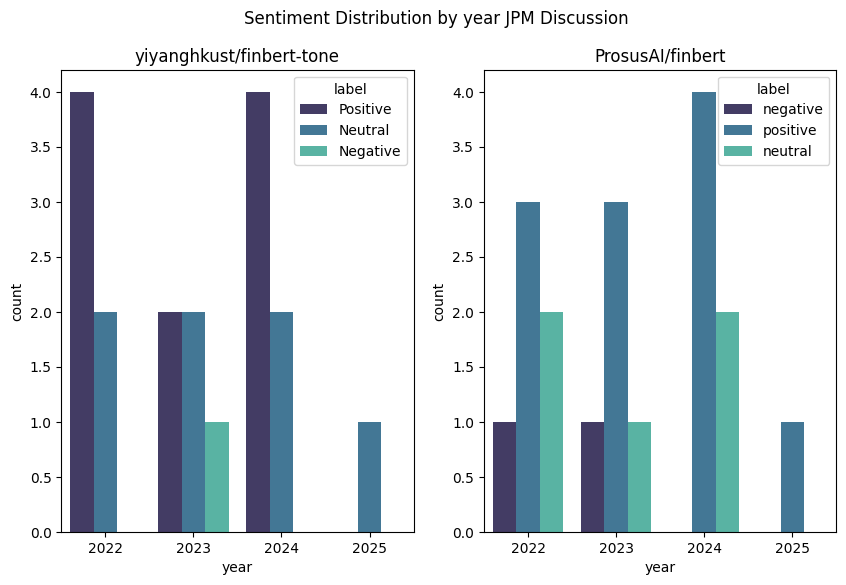

In [108]:
fig, ax = plt.subplots(1,2, figsize=(10, 6))
sns.countplot(df_jpm_scored_md_kust, x="year",
              hue="label", palette = 'mako' ,ax=ax[0])
sns.countplot(df_jpm_scored_md_prosus, x="year",
              hue="label", palette ='mako', ax=ax[1])
ax[0].set_title("yiyanghkust/finbert-tone")
ax[1].set_title("ProsusAI/finbert")
plt.suptitle("Sentiment Distribution by year JPM Discussion")
plt.show()

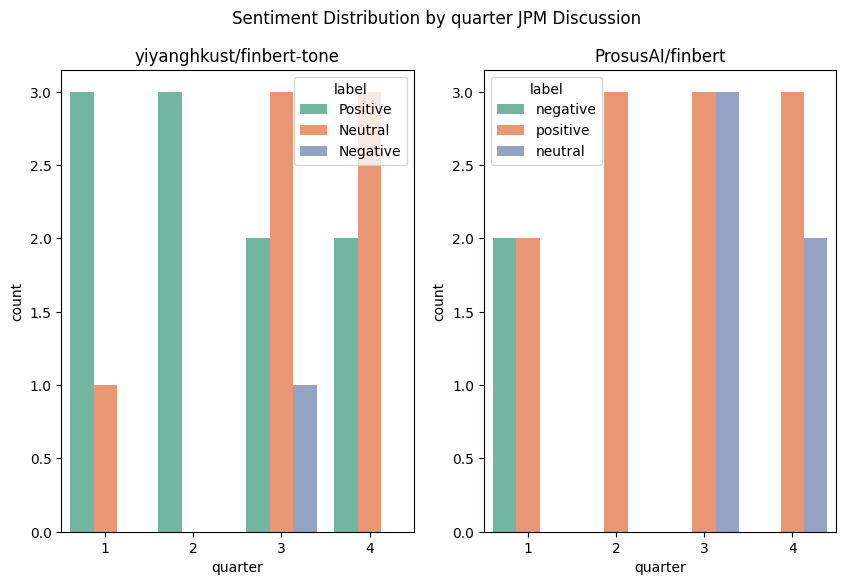

In [109]:
fig, ax = plt.subplots(1,2, figsize=(10, 6))

sns.countplot(df_jpm_scored_md_kust, x="quarter",
              hue = 'label',palette ='Set2', ax=ax[0])

sns.countplot(df_jpm_scored_md_prosus, x="quarter",
              hue = 'label',palette ='Set2', ax=ax[1])
ax[0].set_title("yiyanghkust/finbert-tone")
ax[1].set_title("ProsusAI/finbert")
plt.suptitle("Sentiment Distribution by quarter JPM Discussion")
plt.show()

### Q & A

In [110]:
df_jpm_q_and_a.head()

,question_order,question_answer_group_id,speaker,role,company,content,year,quarter
0,0,0,John McDonald,Analyst,Autonomous Research,"Thank you. Morning, Jeremy. Was wondering abou...",2022,1
1,1,0,Jeremy Barnum,CFO,JP Morgan Chase & Co.,"Good morning, John. Good question. Yeah, look,...",2022,1
2,2,0,John McDonald,Analyst,Autonomous Research,"Okay. And as my follow up, could you give us s...",2022,1
3,3,0,Jeremy Barnum,CFO,JP Morgan Chase & Co.,Yeah. I guess I would direct you to my comment...,2022,1
4,4,0,John McDonald,Analyst,Autonomous Research,Okay. Thanks.,2022,1


In [111]:
df_jpm_q_and_a

,question_order,question_answer_group_id,speaker,role,company,content,year,quarter
0,0,0,John McDonald,Analyst,Autonomous Research,"Thank you. Morning, Jeremy. Was wondering abou...",2022,1
1,1,0,Jeremy Barnum,CFO,JP Morgan Chase & Co.,"Good morning, John. Good question. Yeah, look,...",2022,1
2,2,0,John McDonald,Analyst,Autonomous Research,"Okay. And as my follow up, could you give us s...",2022,1
3,3,0,Jeremy Barnum,CFO,JP Morgan Chase & Co.,Yeah. I guess I would direct you to my comment...,2022,1
4,4,0,John McDonald,Analyst,Autonomous Research,Okay. Thanks.,2022,1
...,...,...,...,...,...,...,...,...
1101,103,0,Jeremy Barnum,CFO,JP Morgan Chase & Co.,Yeah. So you've slightly answered your own que...,2025,1
1102,104,0,Jamie Dimon,CEO,JP Morgan Chase & Co.,Can I just add a management thing that I think...,2025,1
1103,105,0,Saul Martinez,Analyst,Inc.,Okay. That's very clear. Very helpful. Thank you.,2025,1
1104,106,0,Jeremy Barnum,CFO,JP Morgan Chase & Co.,Okay. Thanks very much.,2025,1


In [112]:
df_scored_qa_jpm_kust = score_m_d(df_jpm_q_and_a, MODEL_NAME_1)
df_scored_qa_jpm_kust.head()

Device set to use cuda:0


,question_order,question_answer_group_id,speaker,role,company,content,year,quarter,score,label
0,0,0,John McDonald,Analyst,Autonomous Research,"Thank you. Morning, Jeremy. Was wondering abou...",2022,1,0.998946,Neutral
1,1,0,Jeremy Barnum,CFO,JP Morgan Chase & Co.,"Good morning, John. Good question. Yeah, look,...",2022,1,0.999564,Neutral
2,2,0,John McDonald,Analyst,Autonomous Research,"Okay. And as my follow up, could you give us s...",2022,1,0.999603,Neutral
3,3,0,Jeremy Barnum,CFO,JP Morgan Chase & Co.,Yeah. I guess I would direct you to my comment...,2022,1,0.510577,Negative
4,4,0,John McDonald,Analyst,Autonomous Research,Okay. Thanks.,2022,1,0.981848,Neutral


In [113]:
df_scored_qa_jpm_prosus = score_m_d(df_jpm_q_and_a, MODEL_NAME_2)
df_scored_qa_jpm_prosus.head()

Device set to use cuda:0


,question_order,question_answer_group_id,speaker,role,company,content,year,quarter,score,label
0,0,0,John McDonald,Analyst,Autonomous Research,"Thank you. Morning, Jeremy. Was wondering abou...",2022,1,0.898968,neutral
1,1,0,Jeremy Barnum,CFO,JP Morgan Chase & Co.,"Good morning, John. Good question. Yeah, look,...",2022,1,0.898763,neutral
2,2,0,John McDonald,Analyst,Autonomous Research,"Okay. And as my follow up, could you give us s...",2022,1,0.933247,neutral
3,3,0,Jeremy Barnum,CFO,JP Morgan Chase & Co.,Yeah. I guess I would direct you to my comment...,2022,1,0.740847,neutral
4,4,0,John McDonald,Analyst,Autonomous Research,Okay. Thanks.,2022,1,0.631650,neutral


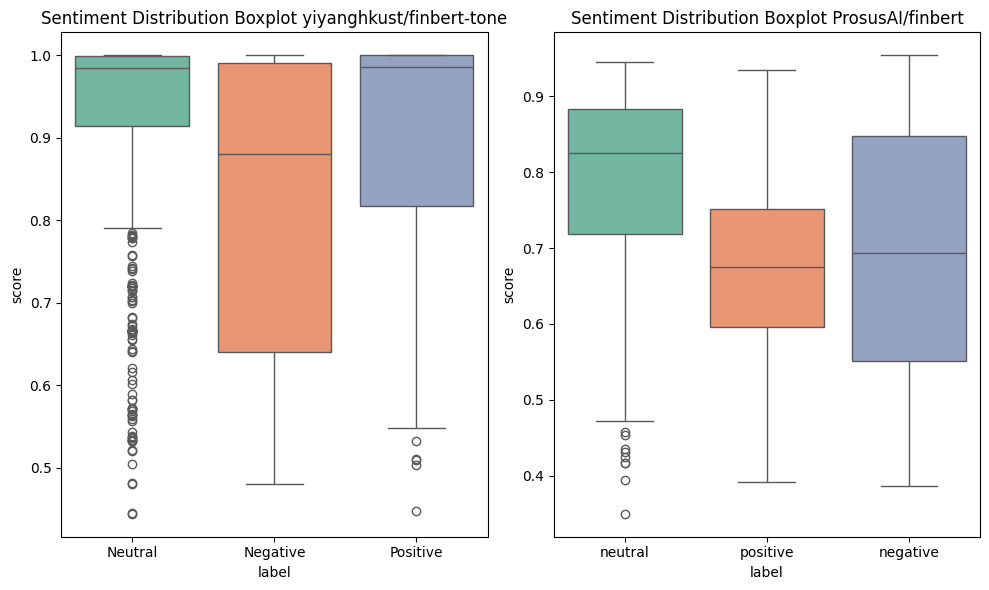

In [114]:
# Graph side by side boxplots
fig, ax = plt.subplots(1,2, figsize=(10, 6))

sns.boxplot(data=df_scored_qa_jpm_kust,
            x="label",
            y="score", palette = 'Set2',  ax=ax[0])
sns.boxplot(data=df_scored_qa_jpm_prosus, x="label",
            y="score", palette ='Set2', ax=ax[1])

ax[0].set_title("Sentiment Distribution Boxplot yiyanghkust/finbert-tone")
ax[1].set_title("Sentiment Distribution Boxplot ProsusAI/finbert")

plt.tight_layout()
plt.show()

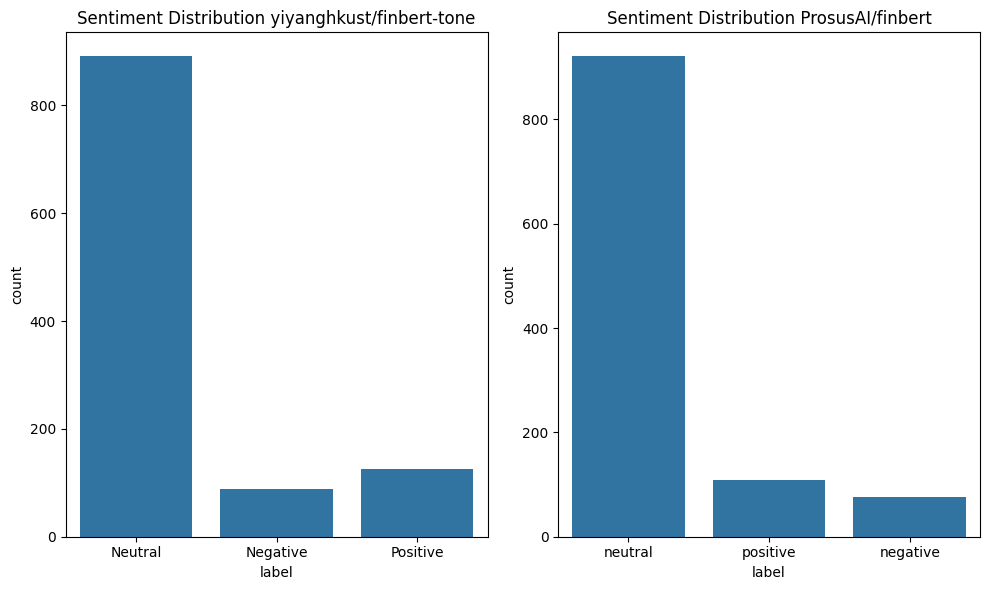

In [115]:
# Graph side by side distribution
fig, ax = plt.subplots(1,2, figsize=(10, 6))

sns.countplot(data= df_scored_qa_jpm_kust, x="label", ax=ax[0])
sns.countplot(data= df_scored_qa_jpm_prosus, x="label", ax=ax[1])

ax[0].set_title("Sentiment Distribution yiyanghkust/finbert-tone")
ax[1].set_title("Sentiment Distribution ProsusAI/finbert")

plt.tight_layout()
plt.show()

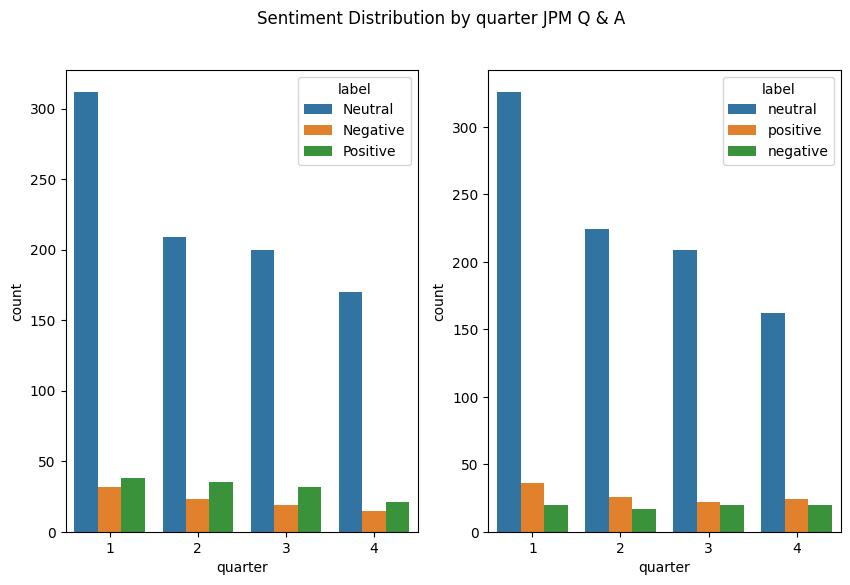

In [116]:
fig, ax = plt.subplots(1,2,figsize=(10, 6))
sns.countplot(df_scored_qa_jpm_kust, x="quarter", hue = 'label', ax=ax[0])
sns.countplot(df_scored_qa_jpm_prosus, x="quarter", hue = 'label', ax=ax[1])
plt.suptitle("Sentiment Distribution by quarter JPM Q & A")
plt.show()

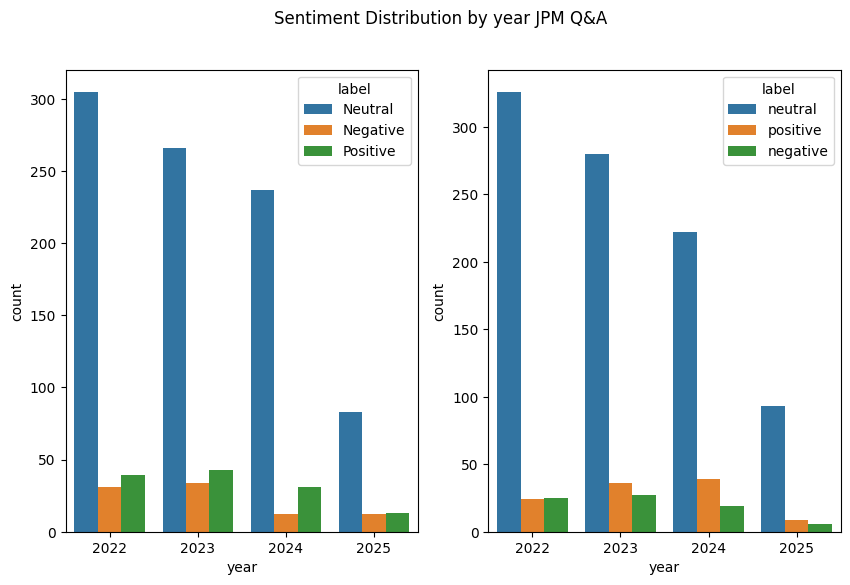

In [117]:
fig, ax = plt.subplots(1,2,figsize=(10, 6))
sns.countplot(df_scored_qa_jpm_kust, x="year", hue = 'label', ax=ax[0])
sns.countplot(df_scored_qa_jpm_prosus, x="year", hue = 'label', ax=ax[1])
plt.suptitle("Sentiment Distribution by year JPM Q&A")
plt.show()

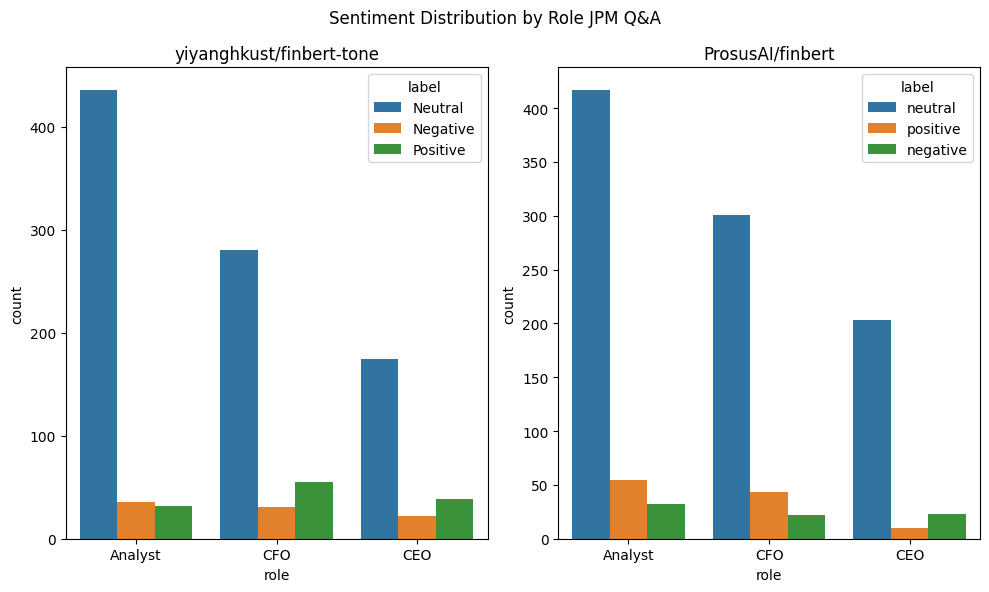

In [118]:
fig, ax = plt.subplots(1,2,figsize=(10, 6))
sns.countplot(df_scored_qa_jpm_kust, x="role", hue = 'label', ax=ax[0])
sns.countplot(df_scored_qa_jpm_prosus, x="role", hue = 'label', ax=ax[1])
ax[0].set_title("yiyanghkust/finbert-tone")
ax[1].set_title("ProsusAI/finbert")
#ax[0].tick_params(axis='x', rotation=45)
#ax[1].tick_params(axis='x', rotation=45)
plt.suptitle("Sentiment Distribution by Role JPM Q&A")
plt.tight_layout()
plt.show()


## Goldman Sachs

### Management Discussion

In [119]:
# yiyanghkust/finbert-tone
df_gs_scored_md_kust = score_m_d(df_gs_discussion,MODEL_NAME_1)
df_gs_scored_md_kust.head()

Device set to use cuda:0


,speaker,role,company,content,quarter,year,score,label
0,Carey Halio,HIR,Goldman Sachs,"Good morning. This is Carey Halio, Head of In...",1,2022,0.999968,Neutral
1,David Solomon,CEO,Goldman Sachs,"Thanks, Carey . Good morning, everyone. Thank...",1,2022,0.999982,Positive
2,Denis Coleman,CFO,Goldman Sachs,"Thank you, David. Good morning. Let's start w...",1,2022,1.000000,Positive
3,Carey Halio,HIR,Goldman Sachs,"Good morning. This is Carey Halio, Head of In...",2,2022,0.999969,Neutral
4,David Solomon,CEO,Goldman Sachs,"Thanks, Carey and good morning everybody . Th...",2,2022,0.999972,Positive


In [120]:
# ProsusAI/finbert
df_gs_scored_md_prosus = score_m_d(df_gs_discussion,MODEL_NAME_2)
df_gs_scored_md_prosus.head()

Device set to use cuda:0


,speaker,role,company,content,quarter,year,score,label
0,Carey Halio,HIR,Goldman Sachs,"Good morning. This is Carey Halio, Head of In...",1,2022,0.949527,neutral
1,David Solomon,CEO,Goldman Sachs,"Thanks, Carey . Good morning, everyone. Thank...",1,2022,0.890292,positive
2,Denis Coleman,CFO,Goldman Sachs,"Thank you, David. Good morning. Let's start w...",1,2022,0.862455,positive
3,Carey Halio,HIR,Goldman Sachs,"Good morning. This is Carey Halio, Head of In...",2,2022,0.948234,neutral
4,David Solomon,CEO,Goldman Sachs,"Thanks, Carey and good morning everybody . Th...",2,2022,0.568493,positive


#### Comparison Graphs

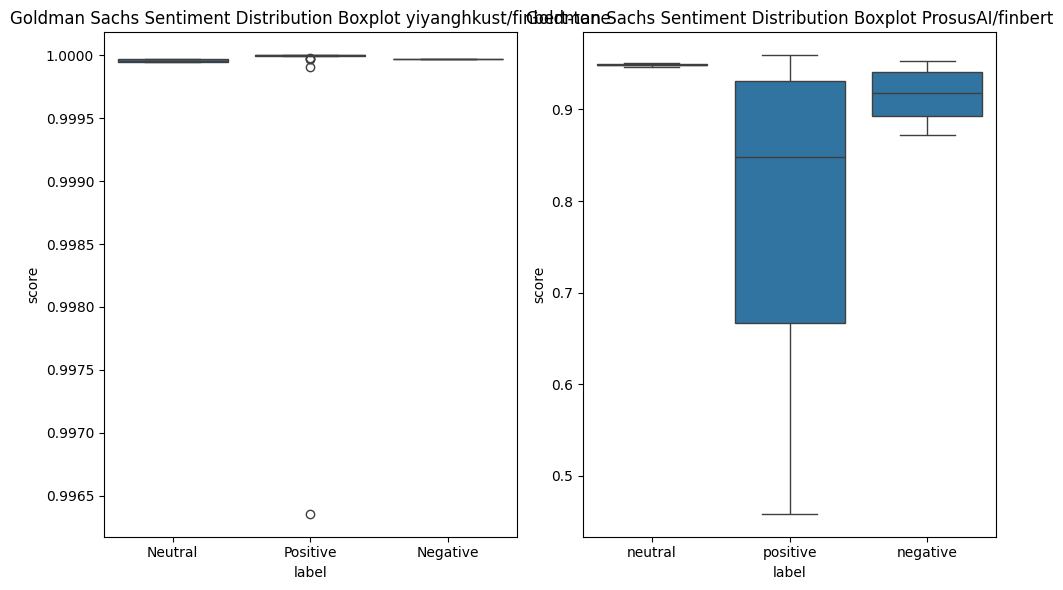

In [121]:
# Graph side by side boxplots
fig, ax = plt.subplots(1,2, figsize=(10, 6))

sns.boxplot(data=df_gs_scored_md_kust, x="label", y="score", ax=ax[0])
sns.boxplot(data=df_gs_scored_md_prosus, x="label", y="score", ax=ax[1])

ax[0].set_title("Goldman Sachs Sentiment Distribution Boxplot yiyanghkust/finbert-tone")
ax[1].set_title("Goldman Sachs Sentiment Distribution Boxplot ProsusAI/finbert")

plt.tight_layout()
plt.show()

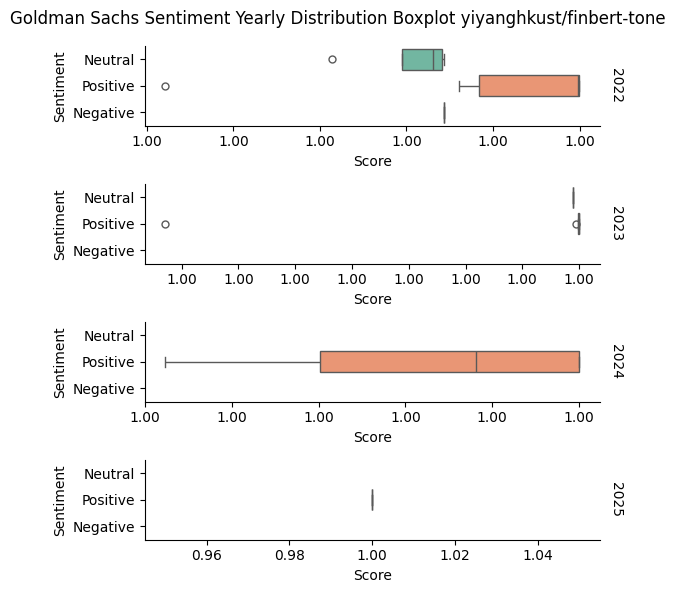

In [122]:
# Graph side by side boxplots of yearly distribution
g_1 = sns.catplot(
    data=df_gs_scored_md_kust,
    x="score", y="label", row="year",
    kind="box", orient="h",
    sharex=False, margin_titles=True,
    height=1.5, aspect=4,
    palette="Set2"
)
g_1.set(xlabel="Score", ylabel="Sentiment")
g_1.set_titles(row_template="{row_name}")
for ax in g_1.axes.flat:
    ax.xaxis.set_major_formatter('{x:.2f}')

plt.suptitle("Goldman Sachs Sentiment Yearly Distribution Boxplot yiyanghkust/finbert-tone")


plt.tight_layout()
plt.show()

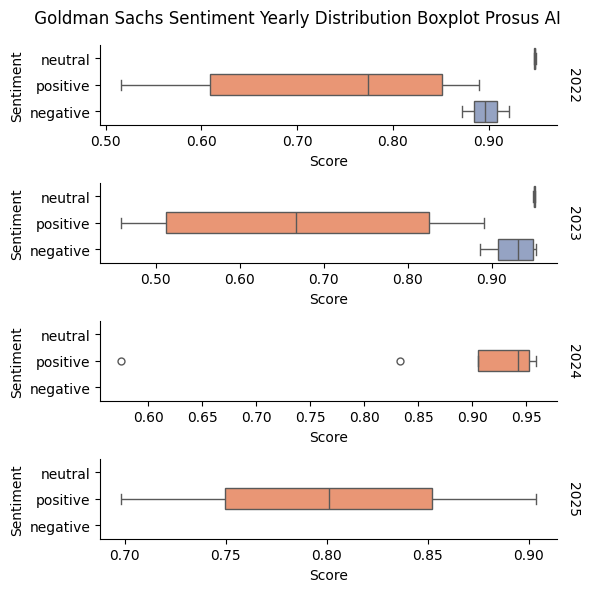

In [123]:
# Graph side by side boxplots of yearly distribution
g_2 = sns.catplot(
    data=df_gs_scored_md_prosus,
    x="score", y="label", row="year",
    kind="box", orient="h",
    sharex=False, margin_titles=True,
    height=1.5, aspect=4,
    palette="Set2"
)
g_2.set(xlabel="Score", ylabel="Sentiment")
g_2.set_titles(row_template="{row_name}")
for ax in g_2.axes.flat:
    ax.xaxis.set_major_formatter('{x:.2f}')

plt.suptitle(" Goldman Sachs Sentiment Yearly Distribution Boxplot Prosus AI")


plt.tight_layout()
plt.show()

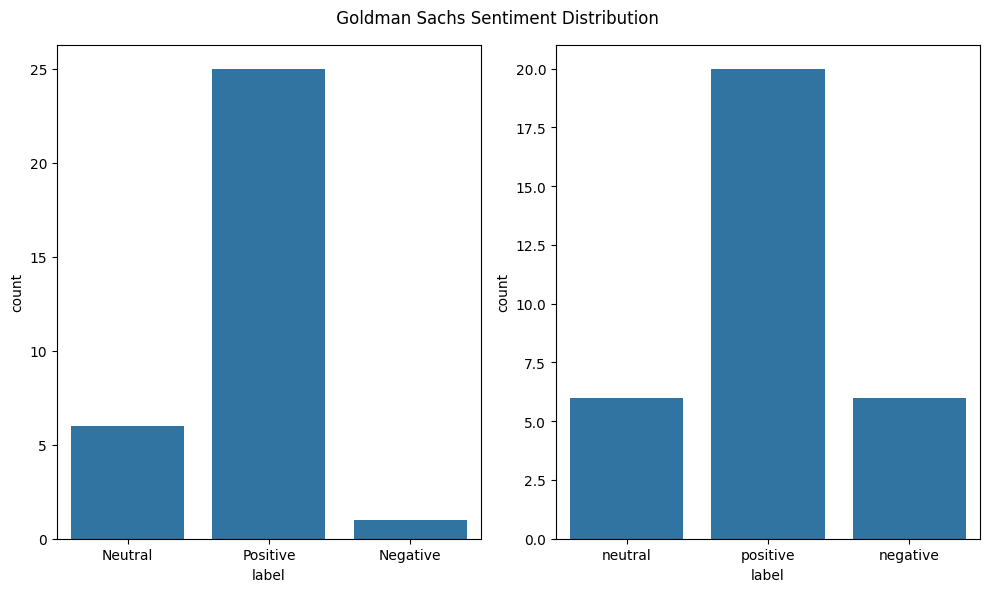

In [124]:
# Graph side by side distribution
fig, ax = plt.subplots(1,2, figsize=(10, 6))

sns.countplot(data=df_gs_scored_md_kust, x="label", ax=ax[0])
sns.countplot(data=df_gs_scored_md_prosus, x="label", ax=ax[1])

plt.suptitle(" Goldman Sachs Sentiment Distribution")

plt.tight_layout()
plt.show()

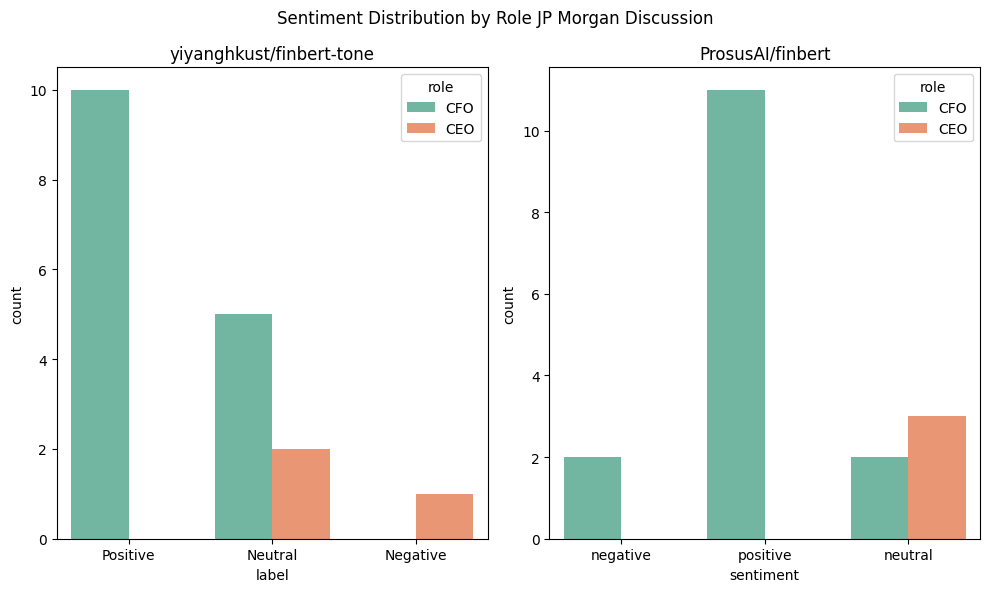

In [139]:
# Graph setiment distribution by role
fig, ax = plt.subplots(1,2, figsize=(10, 6))

sns.countplot(df_jpm_scored_md_kust,
              x="label", hue="role",
              orient = 'h', palette="Set2", ax=ax[0])

sns.countplot(df_jpm_scored_md_prosus,
              x="label", hue="role",
              orient = 'h', palette="Set2", ax=ax[1])

ax[0].set_title("yiyanghkust/finbert-tone")
ax[1].set_title("ProsusAI/finbert")


plt.suptitle("Sentiment Distribution by Role JP Morgan Discussion")
plt.xlabel("sentiment")
plt.ylabel("count")

plt.tight_layout()
plt.show()



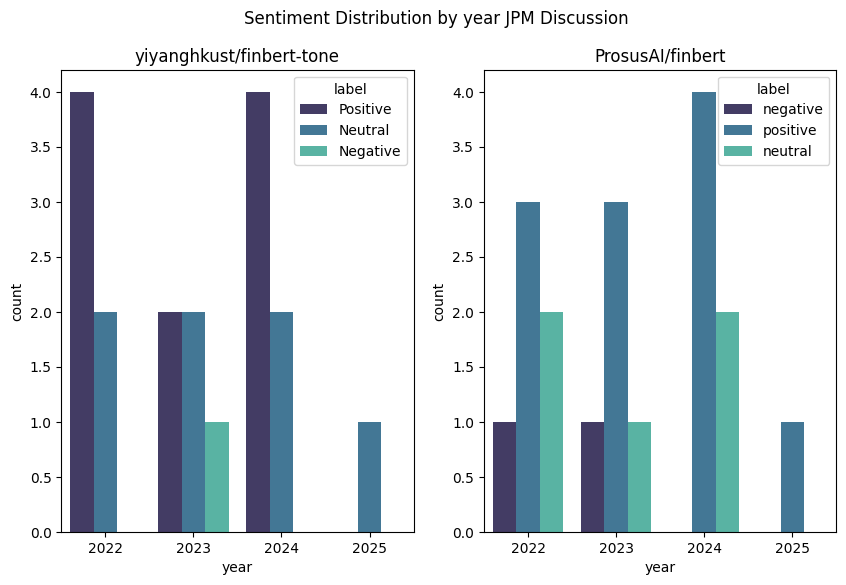

In [126]:
fig, ax = plt.subplots(1,2, figsize=(10, 6))
sns.countplot(df_jpm_scored_md_kust, x="year",
              hue="label", palette = 'mako' ,ax=ax[0])
sns.countplot(df_jpm_scored_md_prosus, x="year",
              hue="label", palette ='mako', ax=ax[1])
ax[0].set_title("yiyanghkust/finbert-tone")
ax[1].set_title("ProsusAI/finbert")
plt.suptitle("Sentiment Distribution by year JPM Discussion")
plt.show()

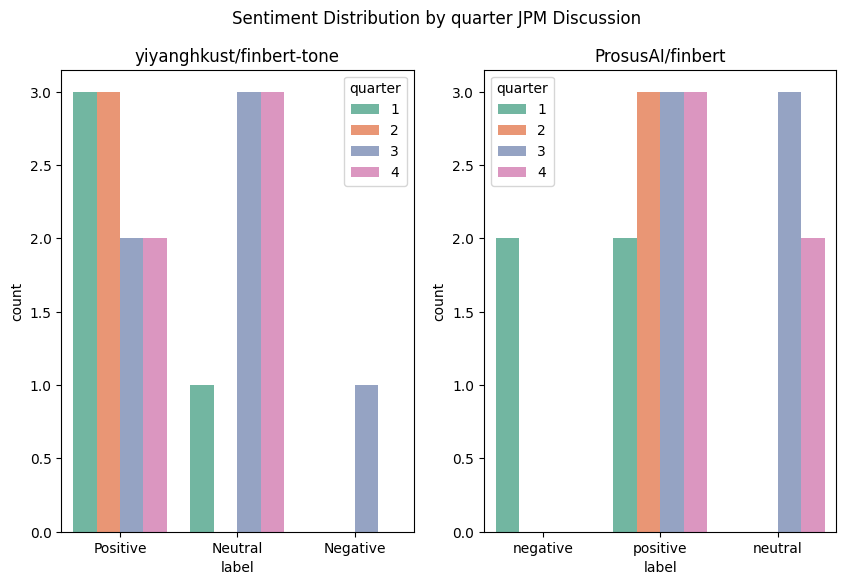

In [138]:
fig, ax = plt.subplots(1,2, figsize=(10, 6))

sns.countplot(df_jpm_scored_md_kust, x="label",
              hue = 'quarter',palette ='Set2', ax=ax[0])

sns.countplot(df_jpm_scored_md_prosus, x="label",
              hue = 'quarter',palette ='Set2', ax=ax[1])
ax[0].set_title("yiyanghkust/finbert-tone")
ax[1].set_title("ProsusAI/finbert")
plt.suptitle("Sentiment Distribution by quarter JPM Discussion")
plt.show()

### Q & A

In [128]:
df_gs_q_and_a.head()

,question_order,question_answer_group_id,speaker,role,company,content_type,content,quarter,year
0,0,0,Glenn Schorr,Analyst,Evercore,question,"so, trading question, i mean, markets busines...",3,2024
1,1,0,David Solomon,CEO,Goldman Sachs,answer,"i appreciate the question, glenn, and i mean,...",3,2024
2,2,0,Glenn Schorr,Analyst,Evercore,question,i appreciate that. this one will be a short f...,3,2024
3,3,0,Denis Coleman,CFO,Goldman Sachs,answer,"glenn, its denis. i guess what i would sugges...",3,2024
4,0,1,Ebrahim Poonawala,Analyst,Bank of America,question,i just had a follow-up ﬁrst on trading and ma...,3,2024


In [129]:
df_gs_q_and_a

,question_order,question_answer_group_id,speaker,role,company,content_type,content,quarter,year
0,0,0,Glenn Schorr,Analyst,Evercore,question,"so, trading question, i mean, markets busines...",3,2024
1,1,0,David Solomon,CEO,Goldman Sachs,answer,"i appreciate the question, glenn, and i mean,...",3,2024
2,2,0,Glenn Schorr,Analyst,Evercore,question,i appreciate that. this one will be a short f...,3,2024
3,3,0,Denis Coleman,CFO,Goldman Sachs,answer,"glenn, its denis. i guess what i would sugges...",3,2024
4,0,1,Ebrahim Poonawala,Analyst,Bank of America,question,i just had a follow-up ﬁrst on trading and ma...,3,2024
...,...,...,...,...,...,...,...,...,...
706,1,11,Denis Coleman,CFO,Goldman Sachs,answer,sure. thank you for that. in terms of a quart...,3,2022
707,2,11,Jeremy Sigee,Analyst,BNP Paribas,question,very clear . and then a separate follow-up ju...,3,2022
708,3,11,David Solomon,CEO,Goldman Sachs,answer,"so i appreciate the question, jeremy . i mean...",3,2022
709,0,12,Mike Mayo,Analyst,Wells Fargo,question,i guess the word for the quarter is resilienc...,3,2022


In [130]:
df_scored_qa_gs_kust = score_m_d(df_gs_q_and_a, MODEL_NAME_1)
df_scored_qa_gs_kust.head()


Device set to use cuda:0


,question_order,question_answer_group_id,speaker,role,company,content_type,content,quarter,year,score,label
0,0,0,Glenn Schorr,Analyst,Evercore,question,"hi. thanks very much. so, i appreciate the $1...",1,2022,0.993975,Neutral
1,1,0,Denis Coleman,CFO,Goldman Sachs,answer,"so glenn, it's denis. thank you. thank you fo...",1,2022,0.999999,Positive
2,2,0,Glenn Schorr,Analyst,Evercore,question,okay . i appreciate that it's working so far ...,1,2022,0.936624,Neutral
3,3,0,David Solomon,CEO,Goldman Sachs,answer,"sure, glenn, it's david. and i'll jump in her...",1,2022,0.998957,Positive
4,0,1,Christian Bolu,Analyst,Autonomous Research,question,good morning. so overall rote of 16% was pret...,1,2022,0.999954,Positive


In [131]:
df_scored_qa_gs_kust.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 711 entries, 0 to 710
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   question_order            711 non-null    int64  
 1   question_answer_group_id  711 non-null    int64  
 2   speaker                   711 non-null    object 
 3   role                      711 non-null    object 
 4   company                   711 non-null    object 
 5   content_type              711 non-null    object 
 6   content                   711 non-null    object 
 7   quarter                   711 non-null    int64  
 8   year                      711 non-null    int64  
 9   score                     711 non-null    float64
 10  label                     711 non-null    object 
dtypes: float64(1), int64(4), object(6)
memory usage: 61.2+ KB


In [132]:
df_scored_qa_gs_prosus = score_m_d(df_gs_q_and_a, MODEL_NAME_2)
df_scored_qa_gs_prosus.head()

Device set to use cuda:0


,question_order,question_answer_group_id,speaker,role,company,content_type,content,quarter,year,score,label
0,0,0,Glenn Schorr,Analyst,Evercore,question,"hi. thanks very much. so, i appreciate the $1...",1,2022,0.814950,neutral
1,1,0,Denis Coleman,CFO,Goldman Sachs,answer,"so glenn, it's denis. thank you. thank you fo...",1,2022,0.755499,positive
2,2,0,Glenn Schorr,Analyst,Evercore,question,okay . i appreciate that it's working so far ...,1,2022,0.716402,positive
3,3,0,David Solomon,CEO,Goldman Sachs,answer,"sure, glenn, it's david. and i'll jump in her...",1,2022,0.742820,neutral
4,0,1,Christian Bolu,Analyst,Autonomous Research,question,good morning. so overall rote of 16% was pret...,1,2022,0.759425,neutral


In [151]:
hir_prosus_content = df_scored_qa_gs_prosus[df_scored_qa_gs_prosus['role'] == 'HIR']['content']

In [154]:
hir_prosus_content

,content
327,but you'll also notice that we reduced our co...


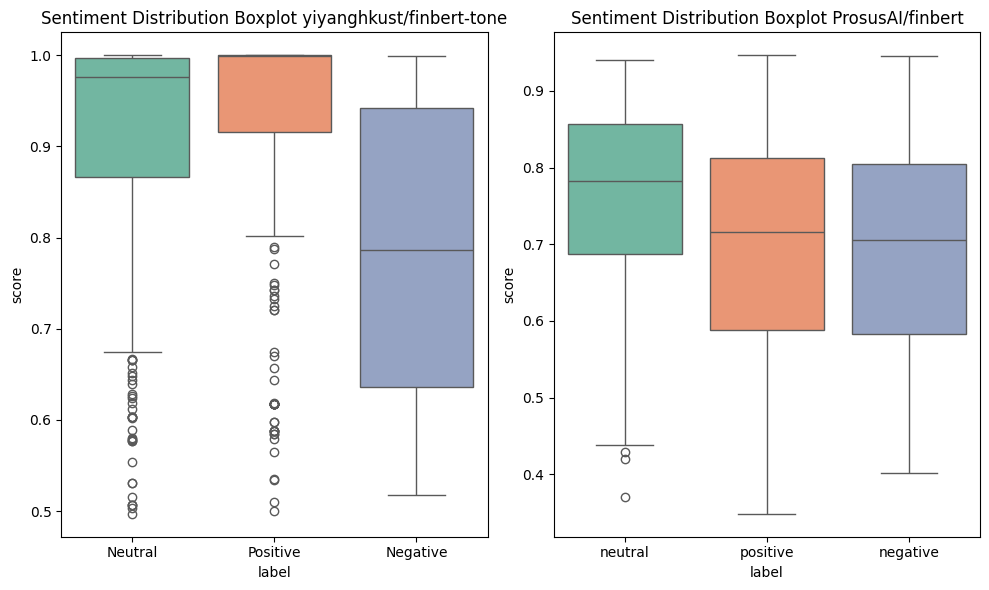

In [133]:
# Graph side by side boxplots
fig, ax = plt.subplots(1,2, figsize=(10, 6))

sns.boxplot(data=df_scored_qa_gs_kust,
            x="label",
            y="score", palette = 'Set2',  ax=ax[0])
sns.boxplot(data=df_scored_qa_gs_prosus, x="label",
            y="score", palette ='Set2', ax=ax[1])

ax[0].set_title("Sentiment Distribution Boxplot yiyanghkust/finbert-tone")
ax[1].set_title("Sentiment Distribution Boxplot ProsusAI/finbert")

plt.tight_layout()
plt.show()

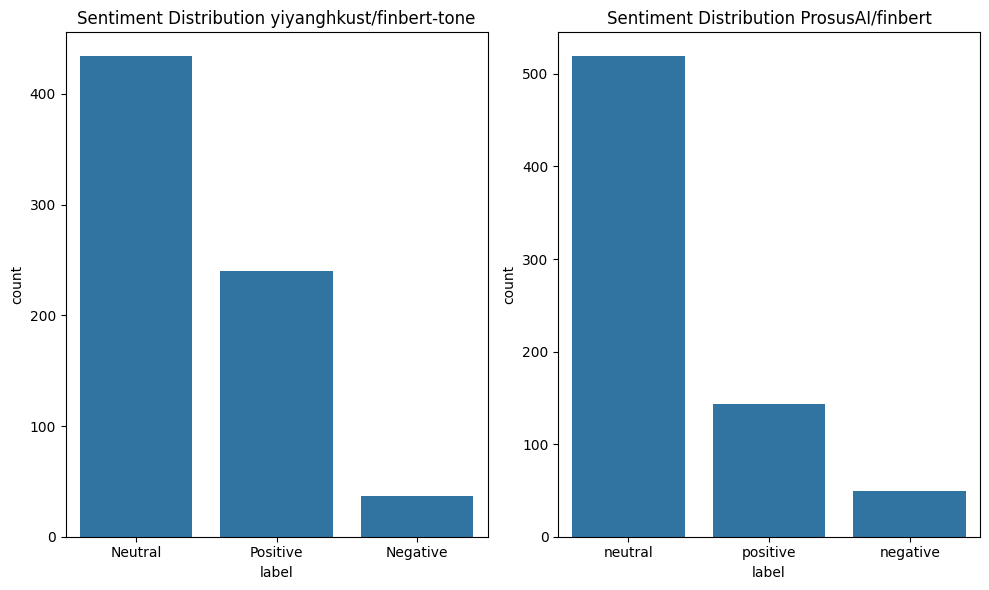

In [134]:
# Graph side by side distribution
fig, ax = plt.subplots(1,2, figsize=(10, 6))

sns.countplot(data= df_scored_qa_gs_kust, x="label", ax=ax[0])
sns.countplot(data= df_scored_qa_gs_prosus, x="label", ax=ax[1])

ax[0].set_title("Sentiment Distribution yiyanghkust/finbert-tone")
ax[1].set_title("Sentiment Distribution ProsusAI/finbert")

plt.tight_layout()
plt.show()

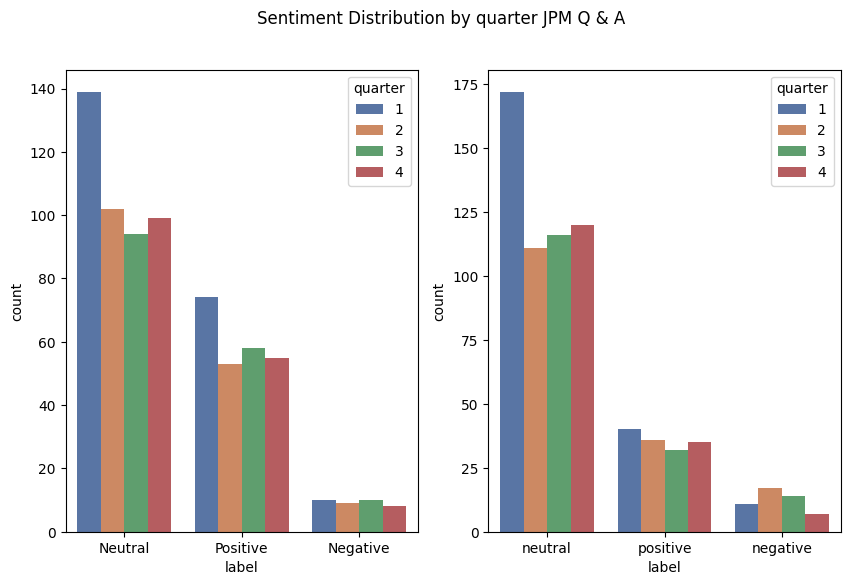

In [142]:
fig, ax = plt.subplots(1,2,figsize=(10, 6))
sns.countplot(df_scored_qa_gs_kust, x="label", hue = 'quarter', ax=ax[0], palette='deep')
sns.countplot(df_scored_qa_gs_prosus, x="label", hue = 'quarter', ax=ax[1], palette='deep')
plt.suptitle("Sentiment Distribution by quarter JPM Q & A")
plt.show()

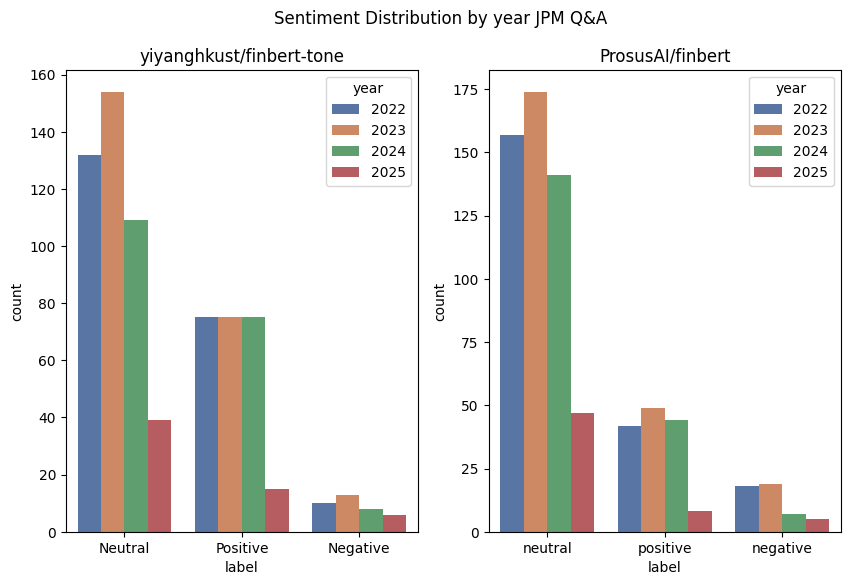

In [143]:
fig, ax = plt.subplots(1,2,figsize=(10, 6))
sns.countplot(df_scored_qa_gs_kust, x="label", hue = 'year', ax=ax[0], palette='deep')
sns.countplot(df_scored_qa_gs_prosus, x="label", hue = 'year', ax=ax[1], palette='deep')
ax[0].set_title("yiyanghkust/finbert-tone")
ax[1].set_title("ProsusAI/finbert")
plt.suptitle("Sentiment Distribution by year JPM Q&A")
plt.show()

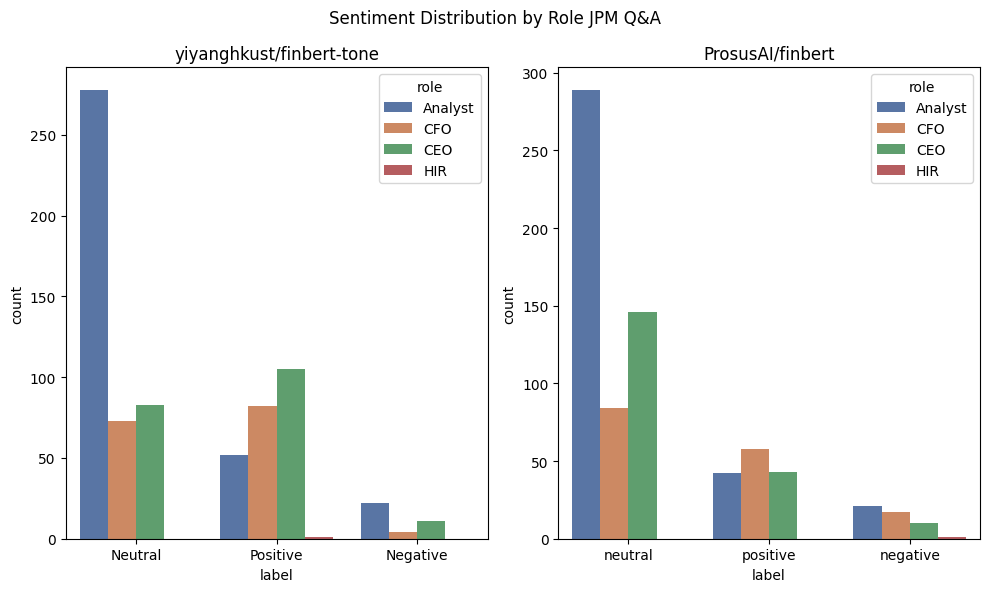

In [145]:
fig, ax = plt.subplots(1,2,figsize=(10, 6))
sns.countplot(df_scored_qa_gs_kust, x="label", hue = 'role', ax=ax[0], palette='deep')
sns.countplot(df_scored_qa_gs_prosus, x="label", hue = 'role', ax=ax[1], palette='deep')
ax[0].set_title("yiyanghkust/finbert-tone")
ax[1].set_title("ProsusAI/finbert")

plt.suptitle("Sentiment Distribution by Role JPM Q&A")
plt.tight_layout()
plt.show()


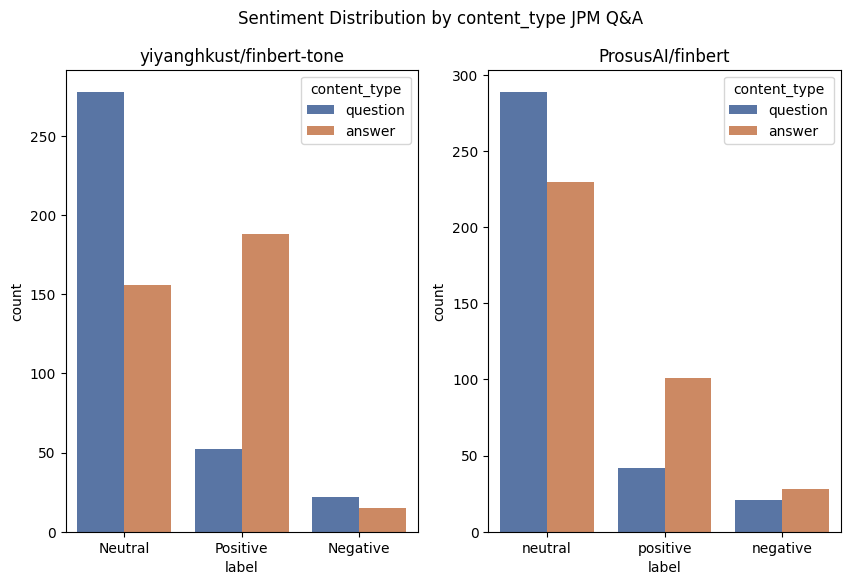

In [165]:
fig, ax = plt.subplots(1,2,figsize=(10, 6))
sns.countplot(df_scored_qa_gs_kust, x="label", hue = 'content_type', ax=ax[0], palette='deep')
sns.countplot(df_scored_qa_gs_prosus, x="label", hue = 'content_type', ax=ax[1], palette='deep')
ax[0].set_title("yiyanghkust/finbert-tone")
ax[1].set_title("ProsusAI/finbert")
plt.suptitle("Sentiment Distribution by Content Type JPM Q&A")
plt.show()

## Negative Sentiment Topic Analysis

## Divide text into various paragraphs

### JPM Discussion

In [162]:
import re
# Create function to analyse paragraphs sentiments
def score_m_d_paragraphs(df, model_1, model_2):

  df =  df.copy()
  df = df.sort_values(by=["year", "quarter"])
  max_length = 512


  tokenizer_1 = AutoTokenizer.from_pretrained(model_1)
  model_1     = AutoModelForSequenceClassification.from_pretrained(model_1)
  tokenizer_2 = AutoTokenizer.from_pretrained(model_2)
  model_2     = AutoModelForSequenceClassification.from_pretrained(model_2)


  # instantiate pipeline
  nlp_1 = pipeline("sentiment-analysis", model=model_1, tokenizer=tokenizer_1)
  nlp_2 = pipeline("sentiment-analysis", model=model_2, tokenizer=tokenizer_2)
  text = df["content"] [0]
  # Split text into paragraphs where a newline is followed by an uppercase letter
  paragraphs = re.split(r'\n(?=[A-Z])', text)

  for i, paragraph in enumerate(paragraphs):
    results_1 = nlp_1(paragraph, truncation=True, max_length=max_length)
    results_2 = nlp_2(paragraph, truncation=True, max_length=max_length)
    print(f"Paragraph {i+1}:")
    print(paragraph)
    print(f"\nyiyanghkust/finbert-tone {results_1}")
    print(f"ProsusAI/finbert {results_2}")
    print("-" * 20) # Separator for clarity


In [163]:
score_m_d_paragraphs(df_jpm_discussion, MODEL_NAME_1, MODEL_NAME_2)

Device set to use cuda:0
Device set to use cuda:0


Paragraph 1:
Thanks, operator. Good morning, everyone. The presentation is available on our website and please refer to the disclaimer in the back.

yiyanghkust/finbert-tone [{'label': 'Neutral', 'score': 0.9994444251060486}]
ProsusAI/finbert [{'label': 'neutral', 'score': 0.9504186511039734}]
--------------------
Paragraph 2:
Starting on page 1, the firm reported net income of $8.3 billion, EPS of $2.63, on revenue of $31.6 billion and delivered an ROTCE of 16%.

yiyanghkust/finbert-tone [{'label': 'Neutral', 'score': 0.9998233914375305}]
ProsusAI/finbert [{'label': 'neutral', 'score': 0.8983671069145203}]
--------------------
Paragraph 3:
These results include approximately $900 million of credit reserve builds, which I'll cover in more detail shortly, as well a s $500 million of
losses in credit adjustmen ts and other in CIB.

yiyanghkust/finbert-tone [{'label': 'Neutral', 'score': 0.8727406859397888}]
ProsusAI/finbert [{'label': 'negative', 'score': 0.8240874409675598}]
-----------

### GS Discussion

In [164]:
score_m_d_paragraphs(df_gs_discussion, MODEL_NAME_1, MODEL_NAME_2)

Device set to use cuda:0
Device set to use cuda:0


Paragraph 1:
 Thank you, operator , good morning, everyone. Thank you all for joining us. In the third quarter , we produced net revenues of $12.7 billion and generated earnings per share of $8.40, an ROE of 10.4% and an ROTE of 1 1.1%. Overall, I am pleased with our performance especially in a quarter where our results were impacted by selected items including the narrowing of our consumer footprint which reduced our ROE by 80 basis points. Our performance demonstrates the strength of our world-class and interconnected franchises where we were ef fectively serving clients in a complex backdrop. Global Banking and Markets, we remained premier M&A  advisor and a leading global risk intermediary . Across investment banking, corporate and sponsors remained actively engaged and we see signiﬁcant pent-up demand from our clients. Our backlog rose again this quarter driven by advisory and we expect our leading investment banking franchises to beneﬁt from the continued resurgence in activity .